In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

import os
import argparse
import pickle
import numpy as np
import pdb
import time
from PIL import Image


import sys
sys.path.insert(1, '../')
from models import *
from utils import progress_bar
from cifar_new import CIFAR_New

In [2]:
print('==> Preparing data..')

all_trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=False, transform=None)

testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=False, transform=None)

testset_new = CIFAR_New(root='../data', transform=None)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


In [3]:
with open("../cifar10_summary.pkl", "rb") as f:
    out = pickle.load(f)

First, look at the overall training and test accuracies

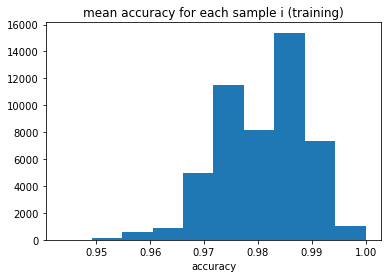

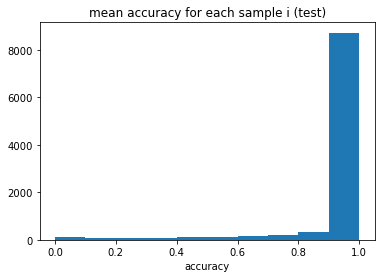

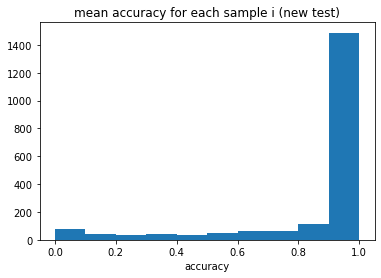

In [4]:
plt.hist(out["acc_train"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (training)")
plt.show()

plt.hist(out["acc_test"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (test)")
plt.show()

plt.hist(out["acc_test_new"].mean(axis = 0))
plt.xlabel("accuracy")
plt.title("mean accuracy for each sample i (new test)")
plt.show()

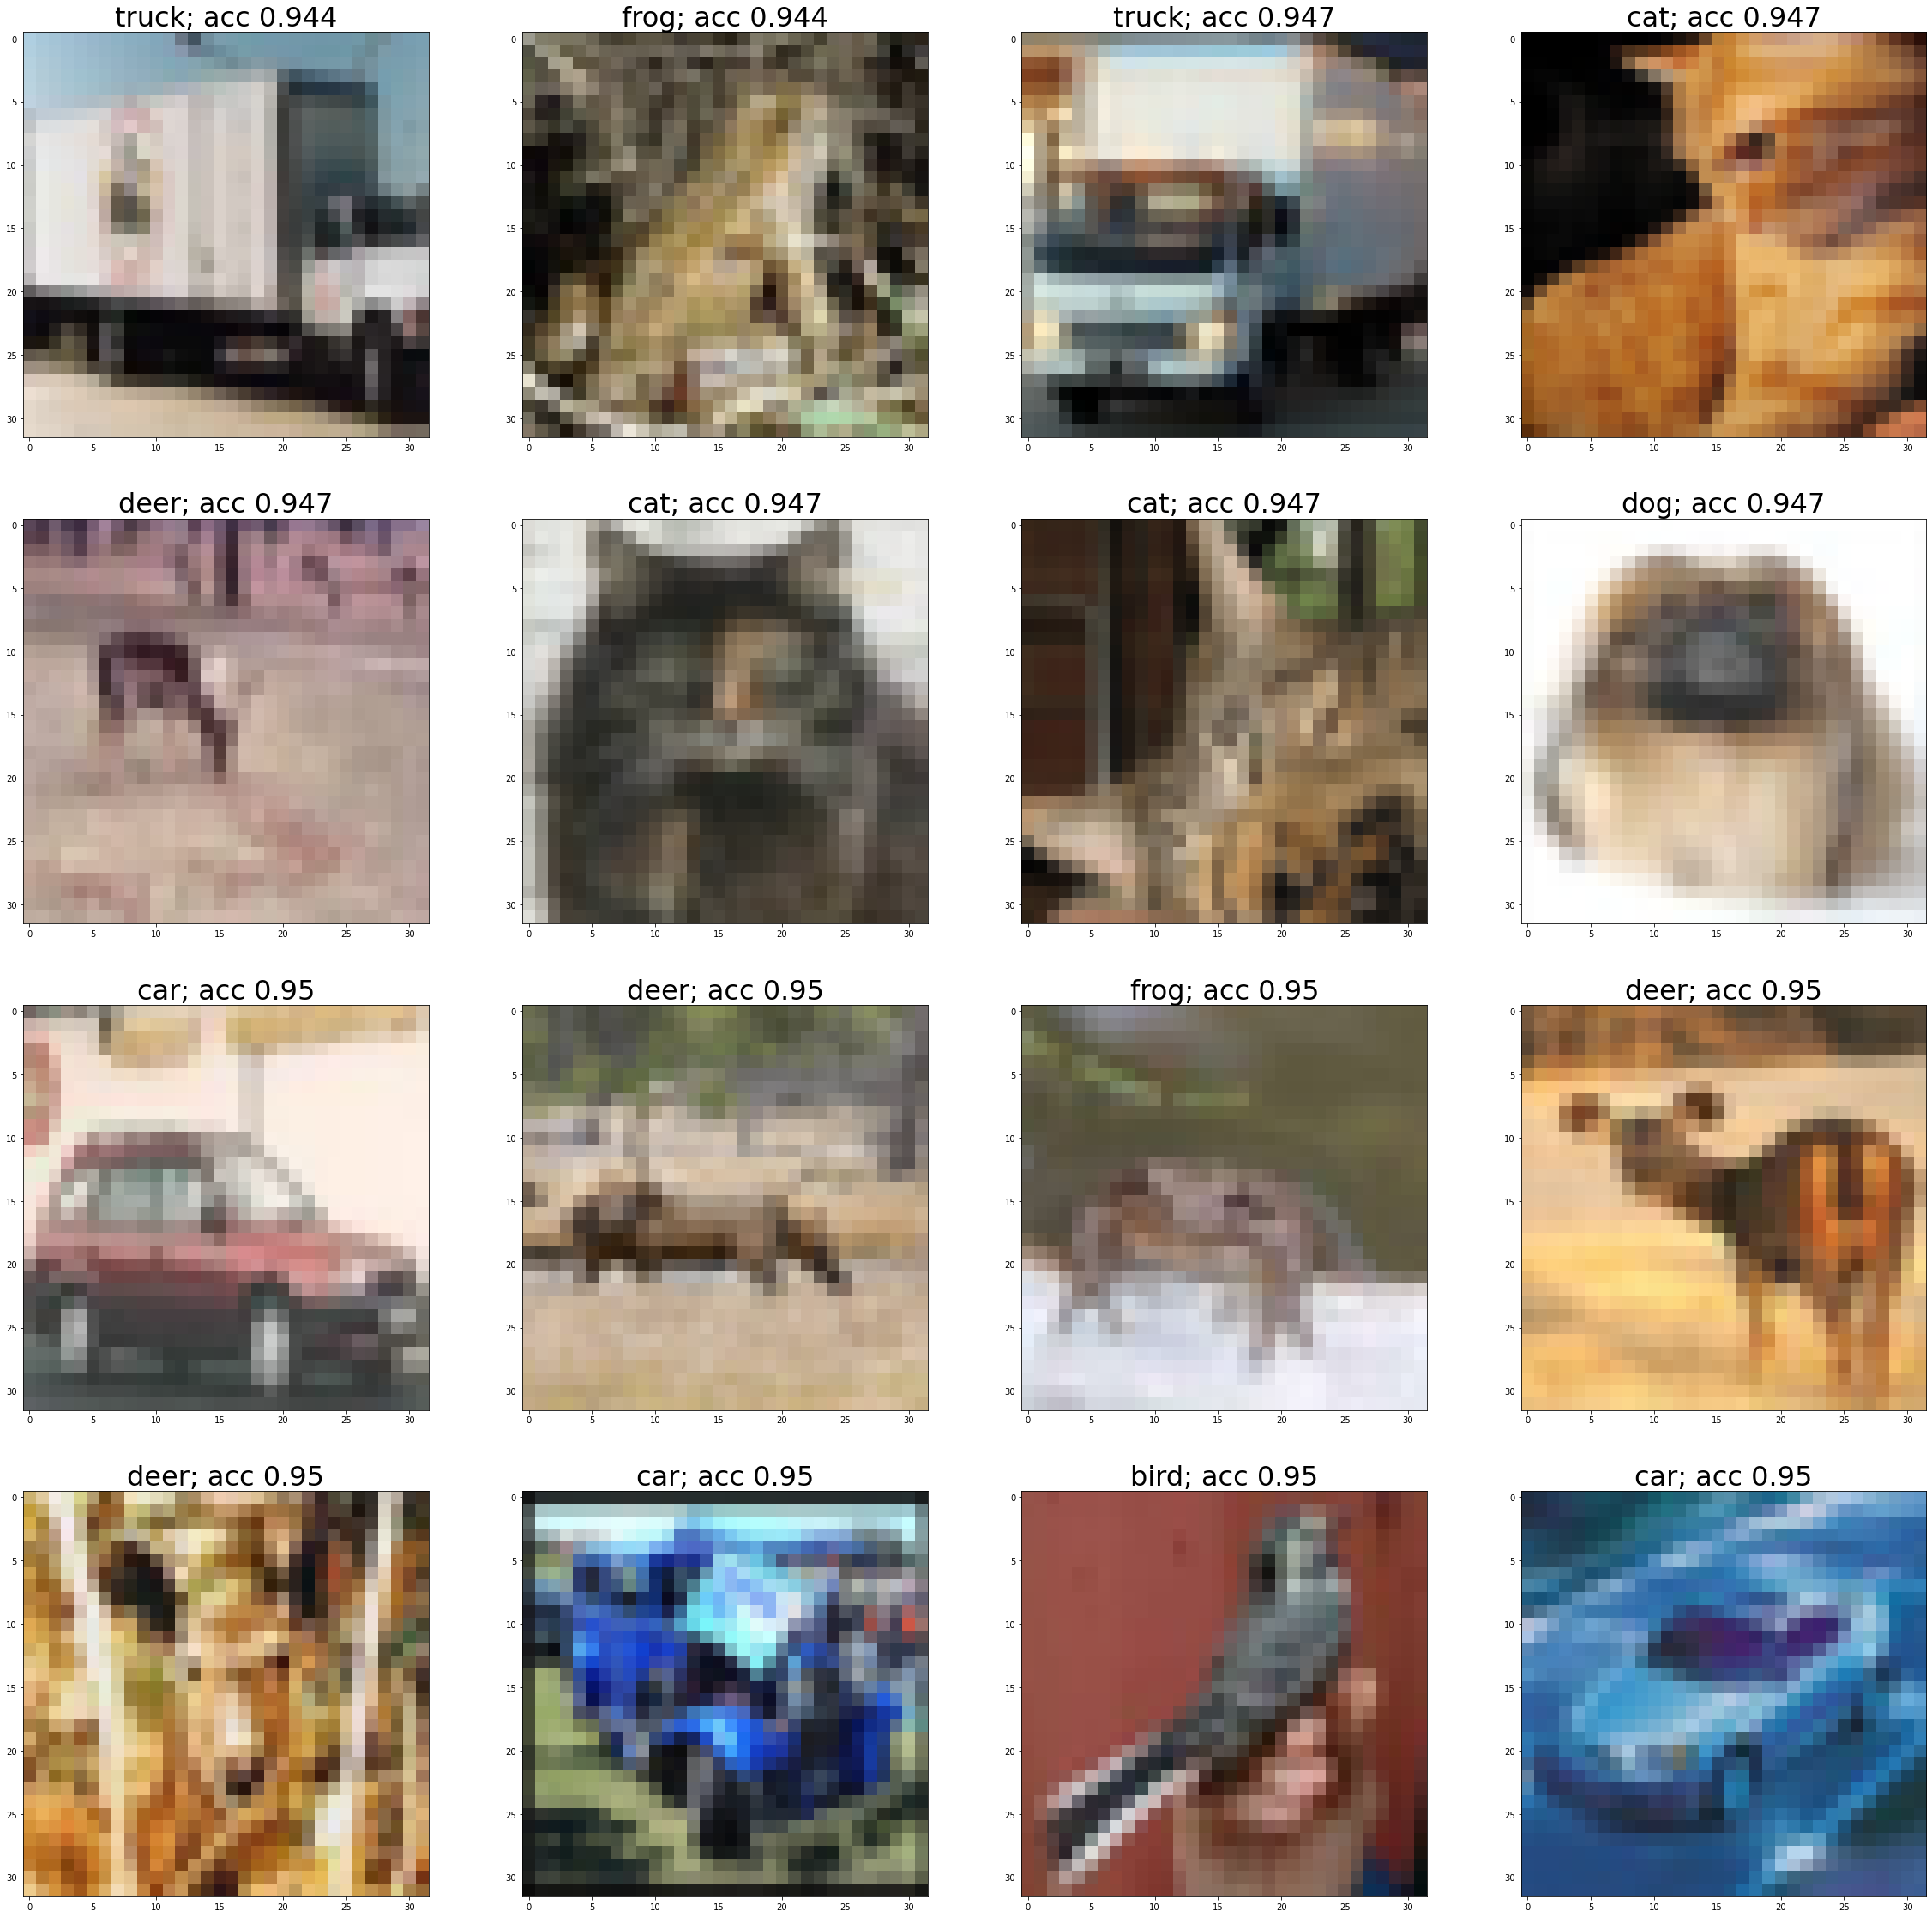

In [5]:
num = 16
columns=4
rows = int(num / columns)
width = 40
height = 40

acc = out["acc_train"].mean(axis = 0)
data = all_trainset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(acc)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; acc {acc[ix].round(3)}", fontsize = 32)
    

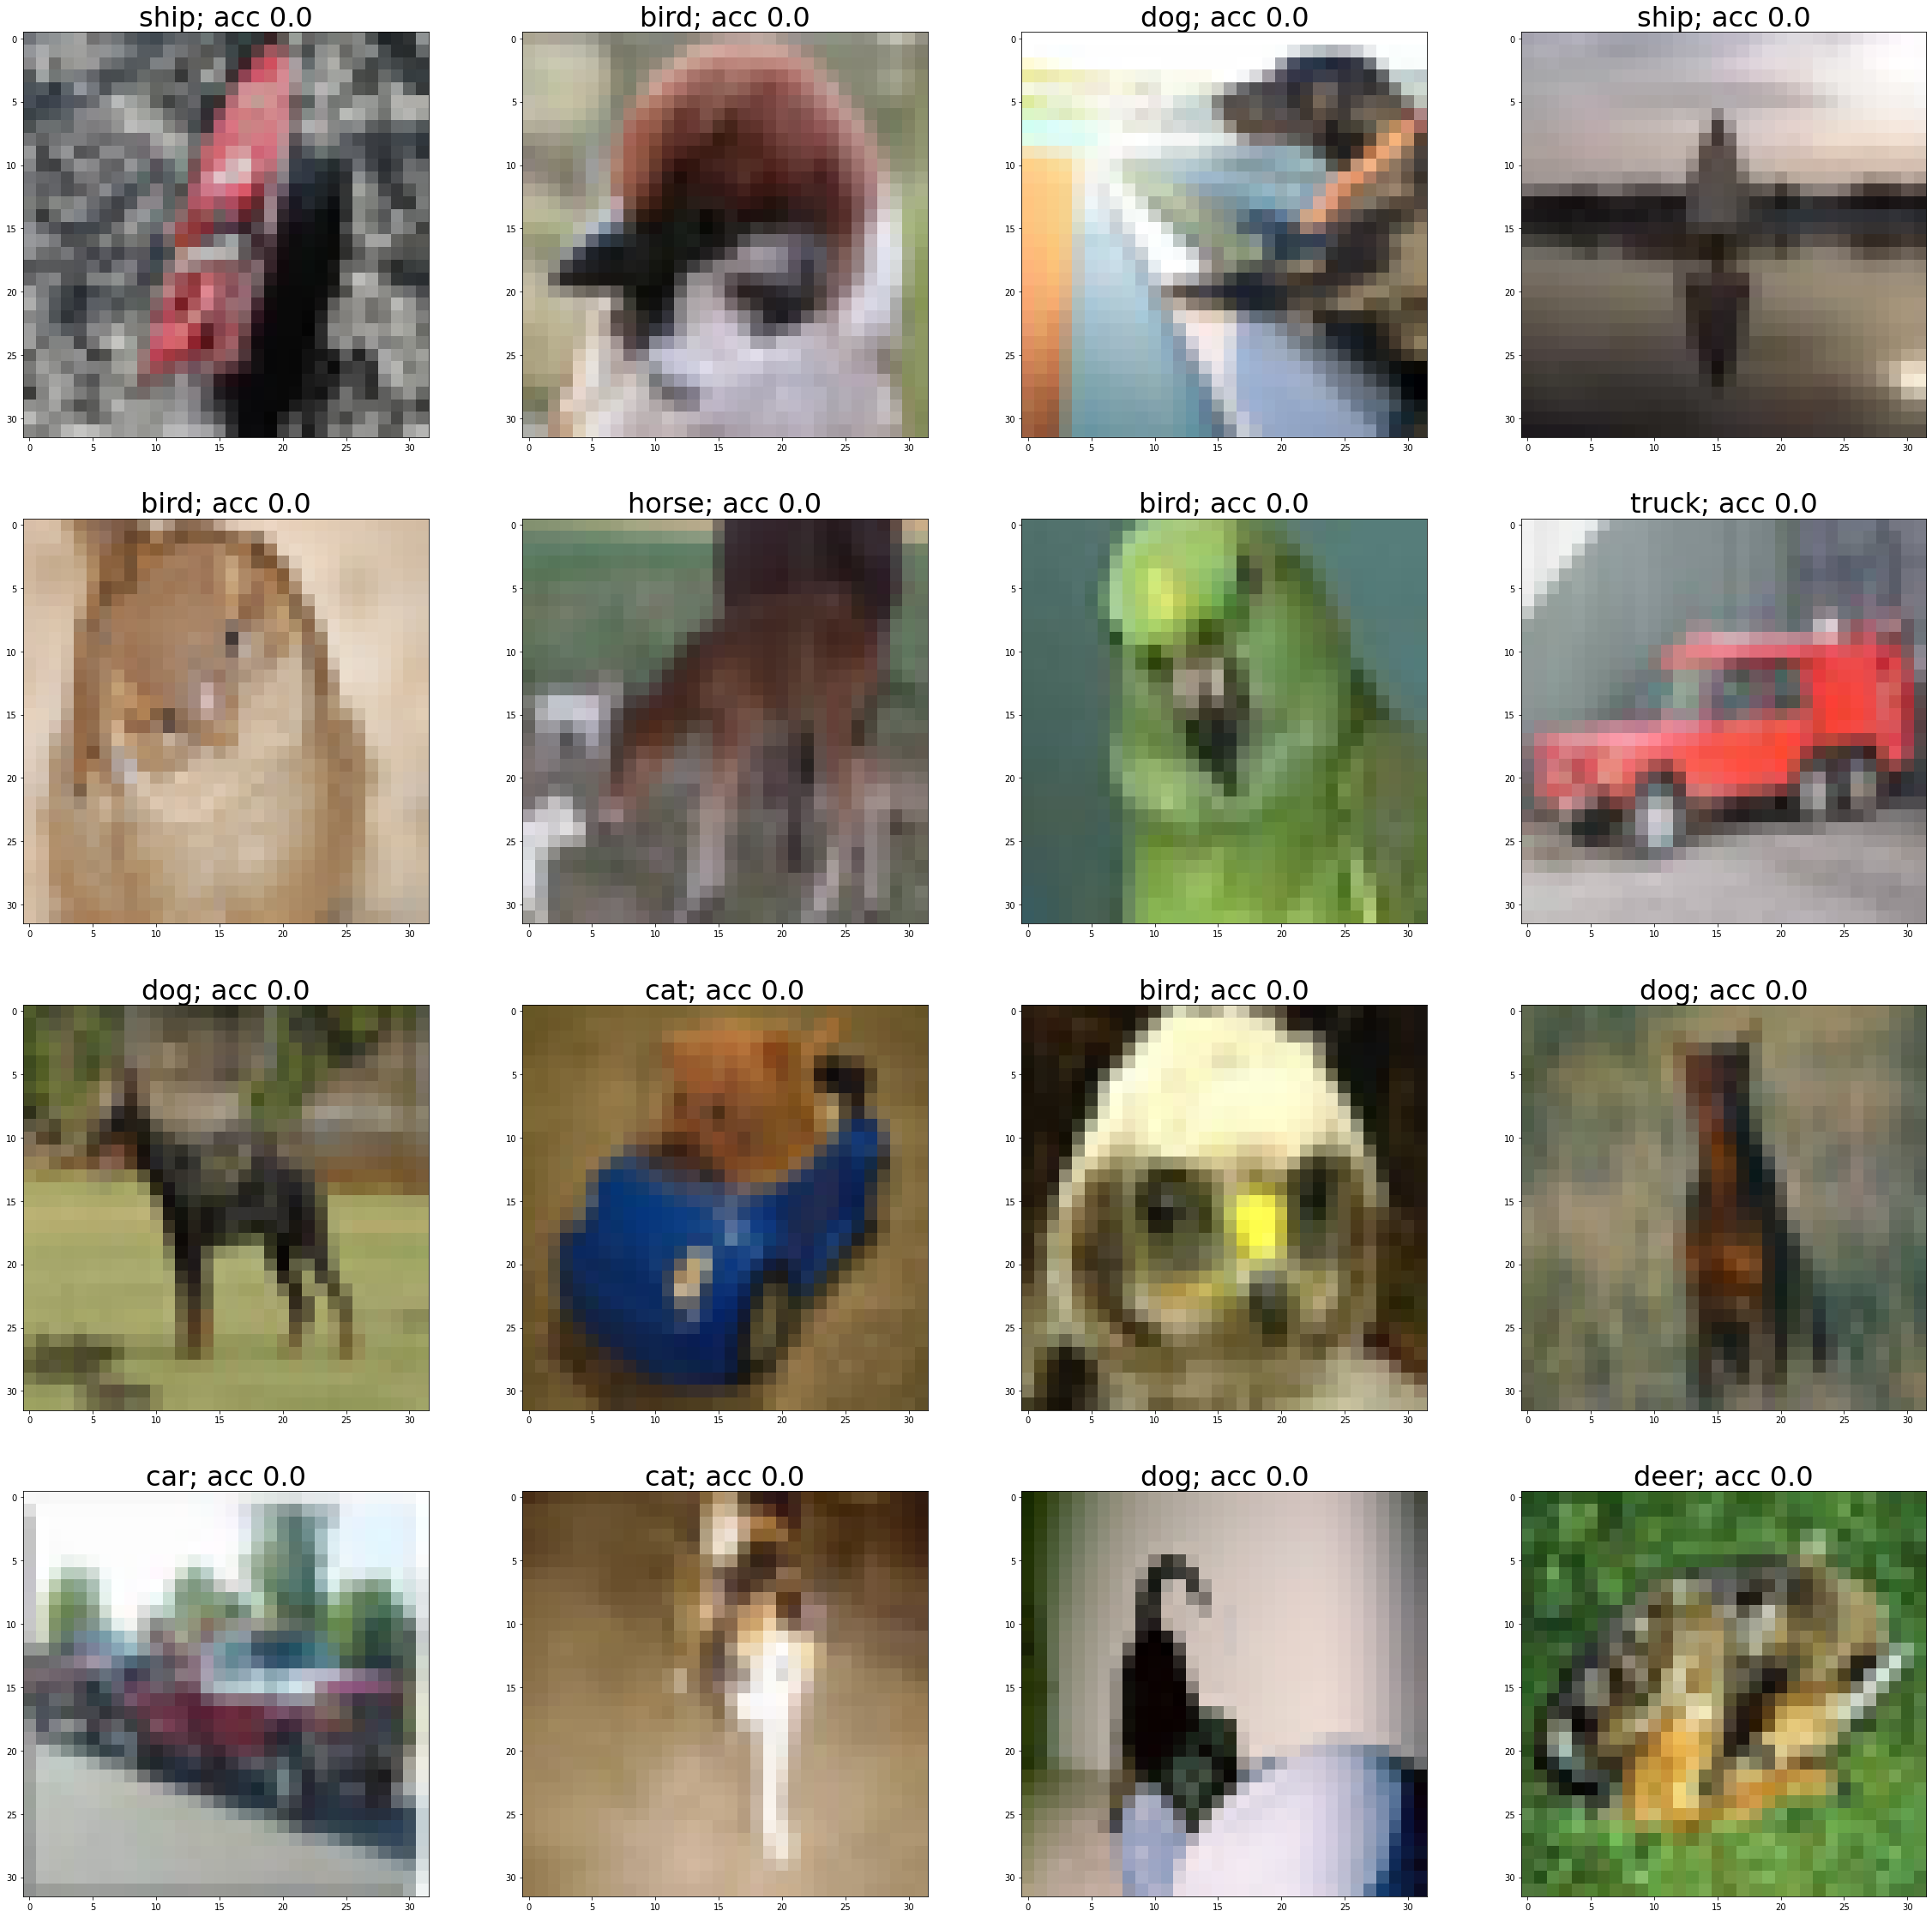

In [6]:
acc = out["acc_test"].mean(axis = 0)
data = testset
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(acc)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; acc {acc[ix].round(3)}", fontsize = 32)

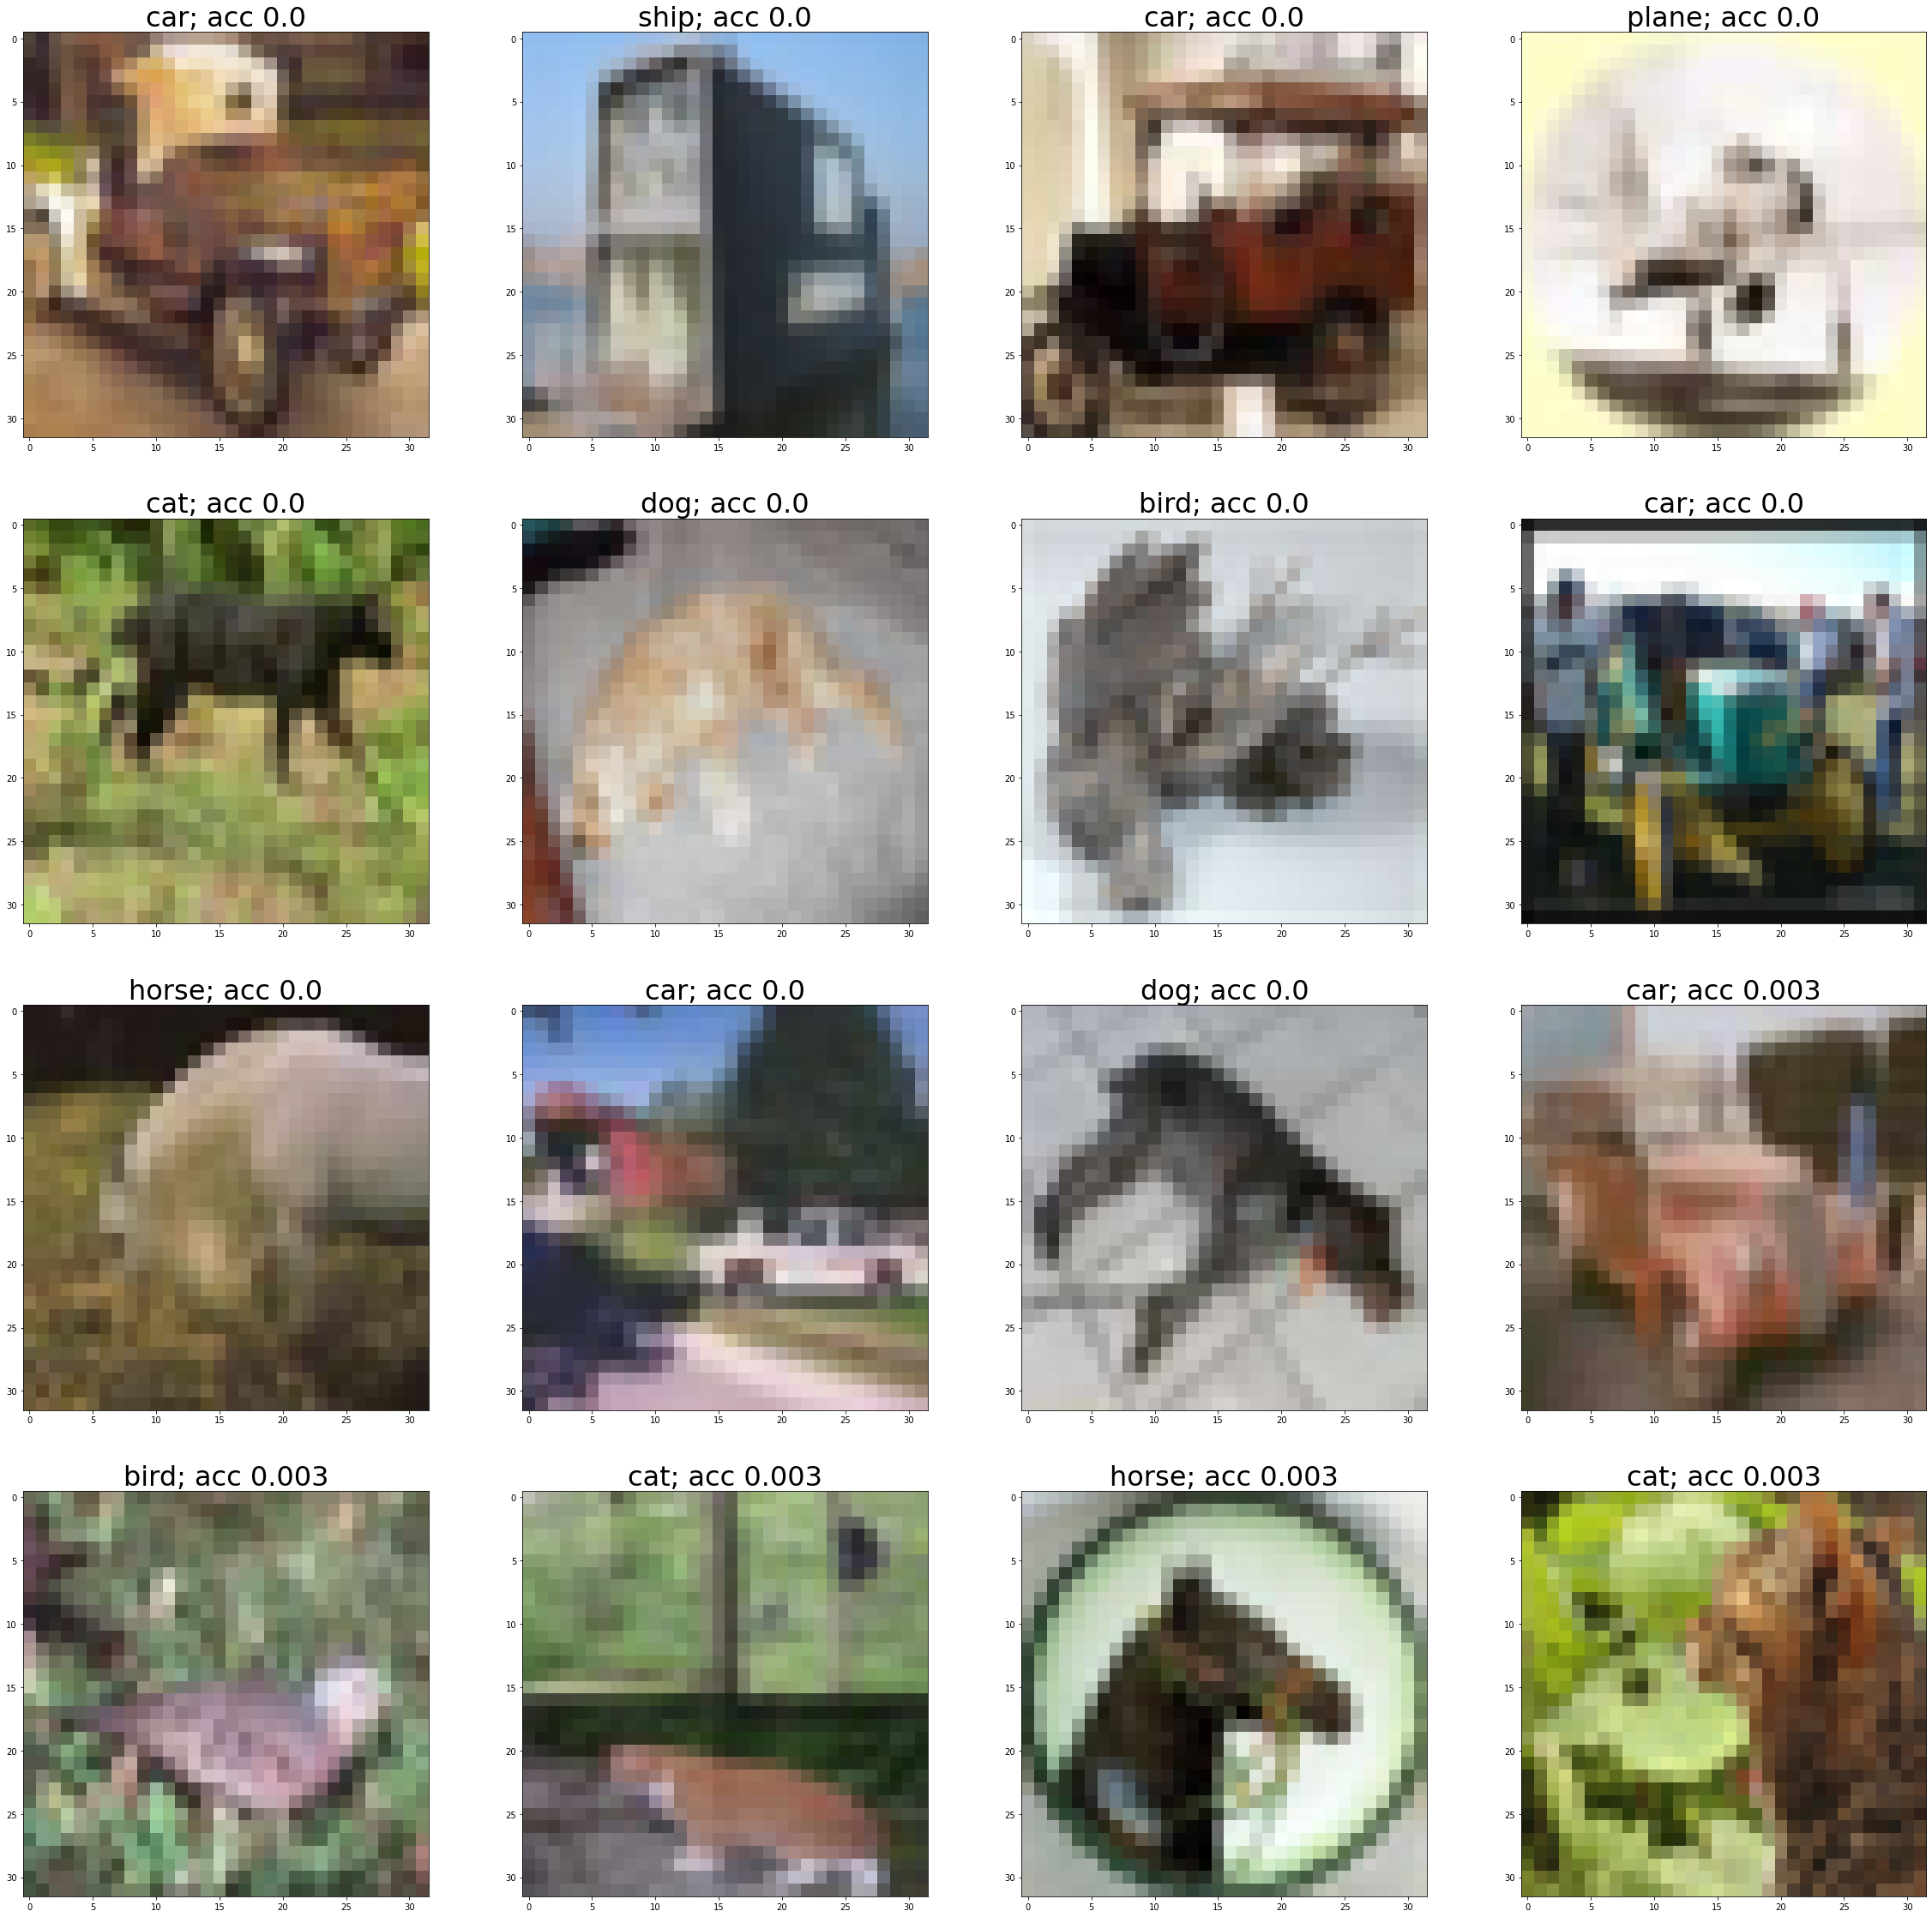

In [7]:
acc = out["acc_test_new"].mean(axis = 0)
data = testset_new
plt.figure(figsize=(width, height))
for i, ix in enumerate(np.argsort(acc)[:num]):        
    image, label = data[ix]
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.title(f"{classes[label]}; acc {acc[ix].round(3)}", fontsize = 32)

## Memory score

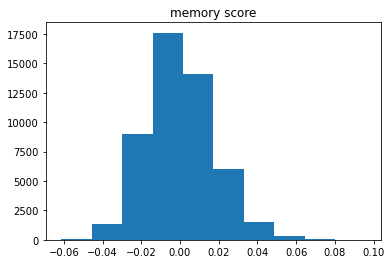

In [8]:
plt.hist(out['mem_score'])
plt.title("memory score")
plt.show()

In [85]:
out['mem_score'].max()

0.09589041095890416

For sample $i$, its memory score should follow $(\mu_i, \sigma_i)$ and $\mu_i > 0$ (I think). But here $\sigma_i$ is too large since I only run around 100 experiments. 

Below look at images with high memory

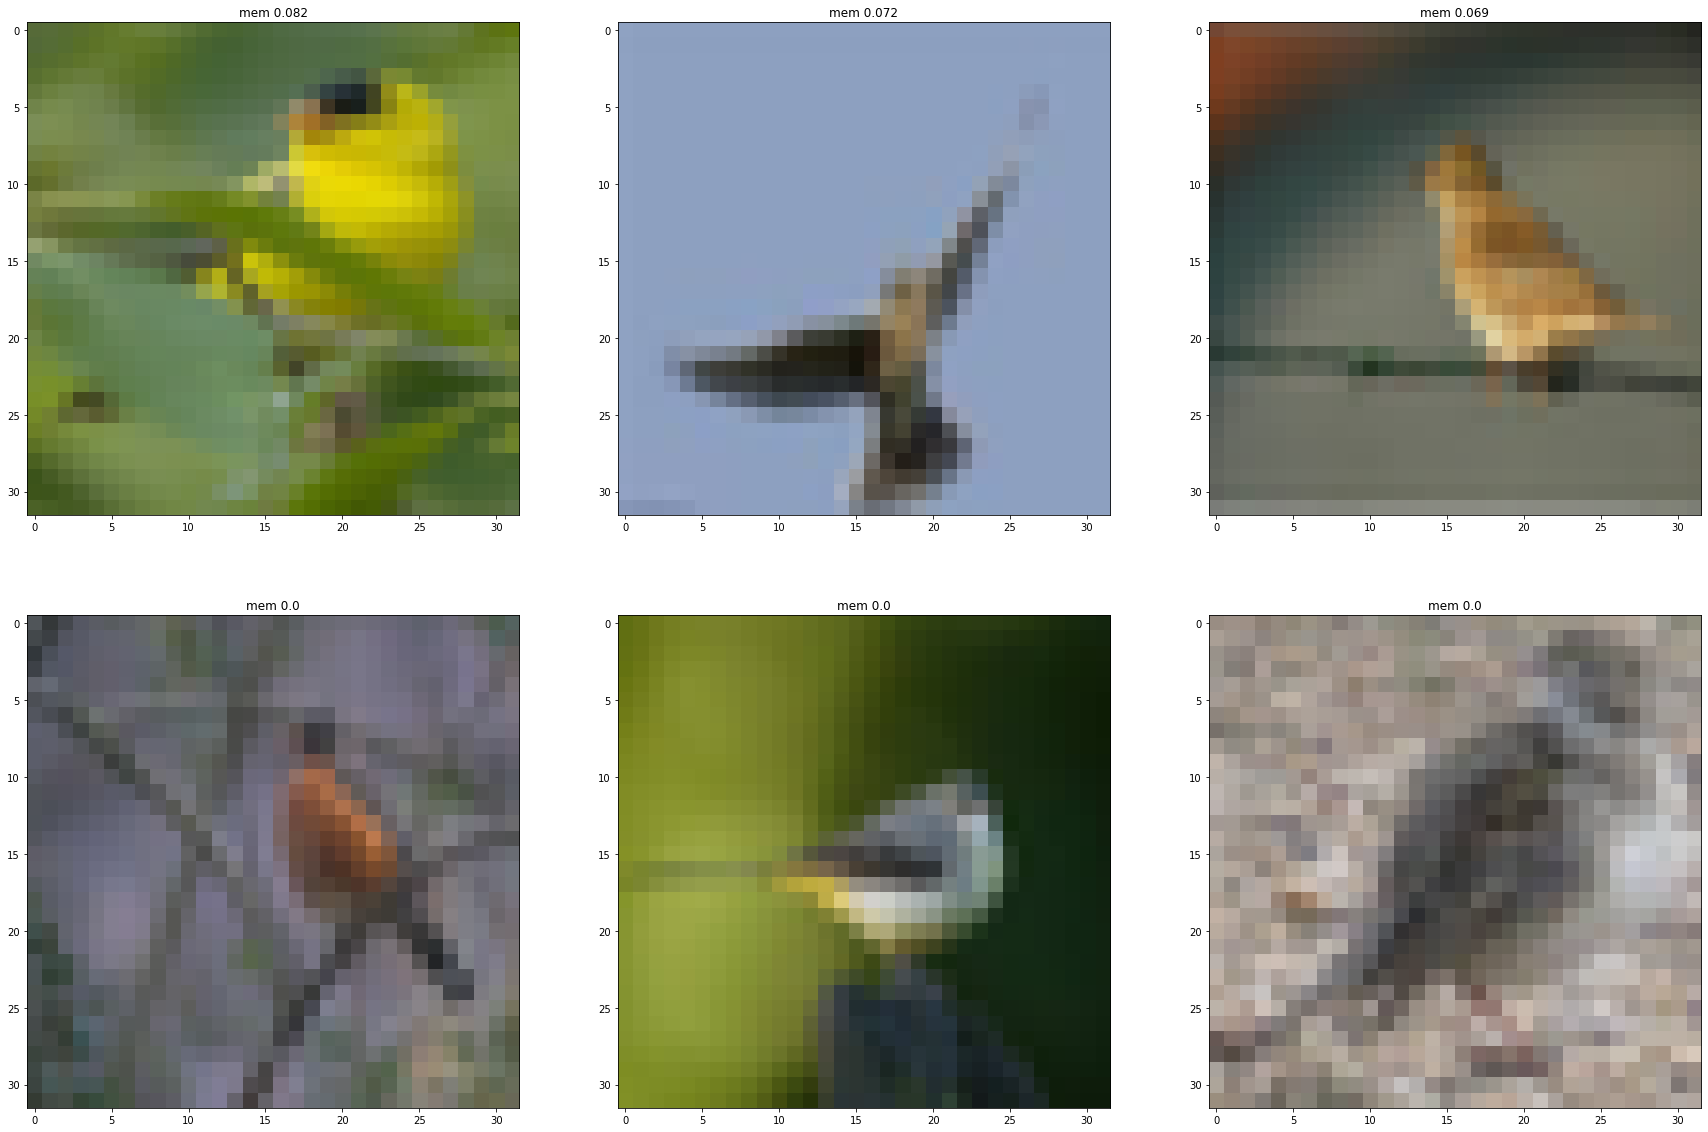

In [10]:
# r,c = np.dstack(np.unravel_index(np.argsort(-val.ravel()), val.shape))[0][i, :]
# val[r, c]

num = 6
columns=3
rows = 2
width = 30
height = 20

label = 2
idx = np.where((np.array(all_trainset.targets)==label))[0]
train_subset = torch.utils.data.Subset(all_trainset, torch.tensor(idx))
mem_ = out["mem_score"][idx]

plt.figure(figsize=(width, height))
idx_ = np.argsort(-mem_)[:3]
for i, ix_ in enumerate(idx_):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(train_subset[ix_][0])
    plt.title(f"mem {mem_[ix_].round(3)}")
    
idx_ = np.argsort(np.abs(mem_))[:3]
for i, ix_ in enumerate(idx_):
    plt.subplot(rows, columns, i + 4)
    plt.imshow(train_subset[ix_][0])
    plt.title(f"mem {mem_[ix_].round(3)}")

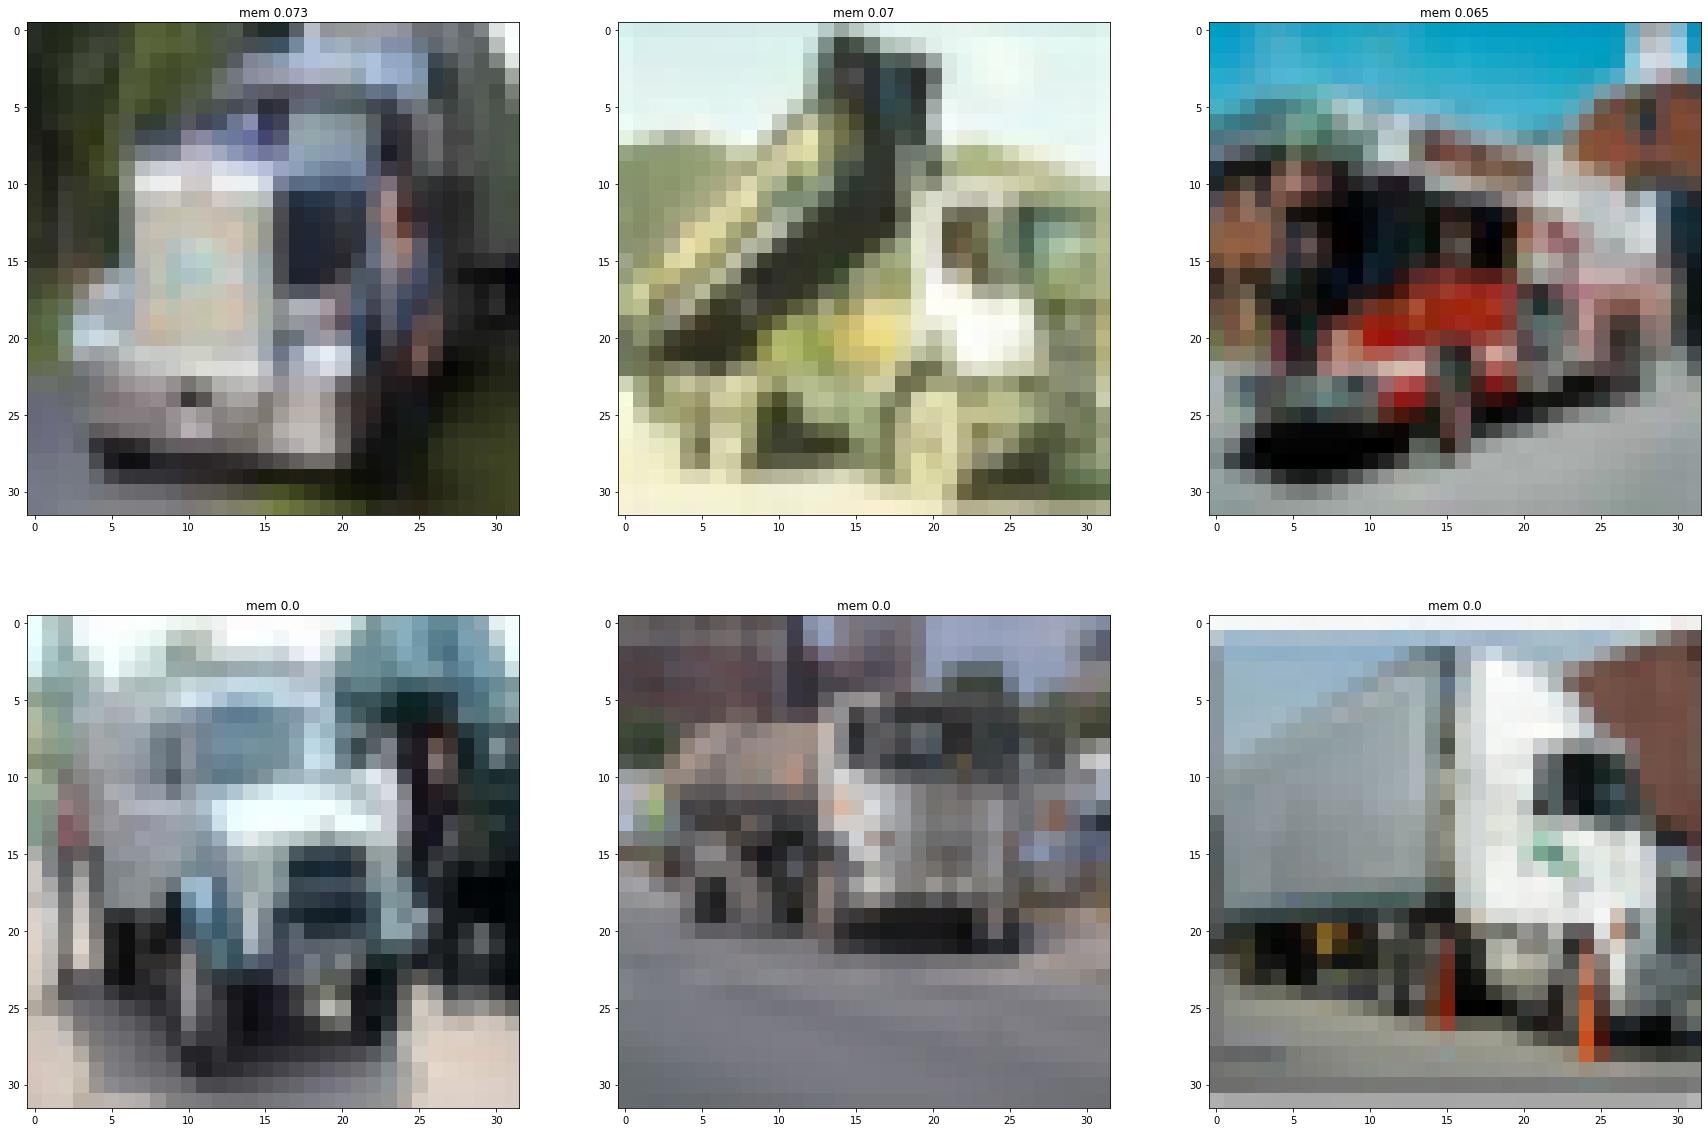

In [11]:
label = 9
idx = np.where((np.array(all_trainset.targets)==label))[0]
train_subset = torch.utils.data.Subset(all_trainset, torch.tensor(idx))
mem_ = out["mem_score"][idx]

plt.figure(figsize=(width, height))
idx_ = np.argsort(-mem_)[:3]
for i, ix_ in enumerate(idx_):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(train_subset[ix_][0])
    plt.title(f"mem {mem_[ix_].round(3)}")
    
idx_ = np.argsort(np.abs(mem_))[:3]
for i, ix_ in enumerate(idx_):
    plt.subplot(rows, columns, i + 4)
    plt.imshow(train_subset[ix_][0])
    plt.title(f"mem {mem_[ix_].round(3)}")

In [12]:
# label = 2
# idx = np.where((np.array(all_trainset.targets)==label))[0]
# train_subset = torch.utils.data.Subset(all_trainset, torch.tensor(idx))
# for i in np.random.choice(5000, 10):
#     plt.imshow(train_subset[i][0])
#     plt.title(f"mem {mem_[i].round(3)}")
#     plt.show()

## Test data

### High-influence pairs

Now let's find the high-infl pairs $(i, j)$. The selection is first based on a cutoff on memory score for $i$ (chosen in the script); then a cutoff for influence for $j$. 

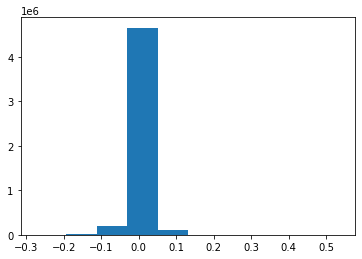

In [13]:
plt.hist(out['infl_score_test'].flatten())
plt.show()

In [14]:
out['infl_score_test'].flatten().shape

(4980000,)

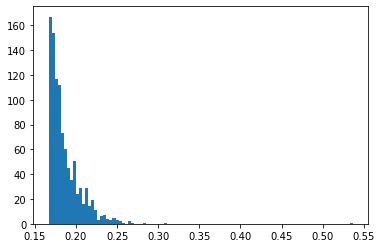

In [15]:
cut = np.quantile(out['infl_score_test'].flatten(), 0.9998) ## should be more careful, but...
hinf_pairs1 = np.where(out['infl_score_test'] > cut)
hinf1 = out['infl_score_test'][out['infl_score_test'] > cut]
plt.hist(hinf1, bins = 100)
plt.show()

# cut = np.quantile(out['infl_score_testnew'].flatten(), 0.9995) ## should be more careful, but...
# hinf_pairs2 = np.where(out['infl_score_testnew'] > cut)
# hinf2 = out['infl_score_testnew'][out['infl_score_testnew'] > cut]
# plt.hist(hinf1, bins = 50)
# plt.hist(hinf2)
# plt.show()

### Training examples with largest influences

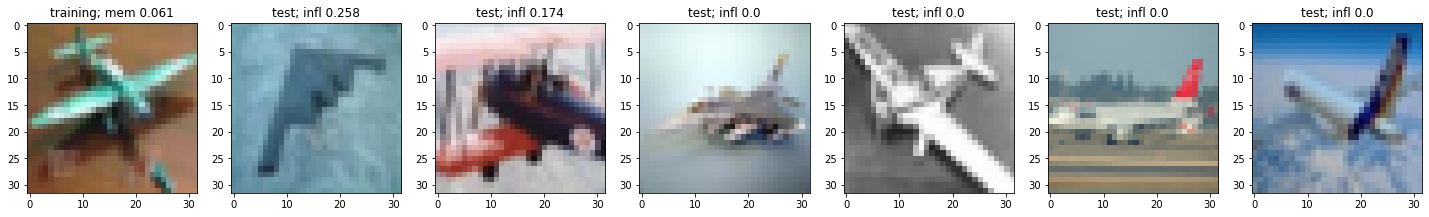

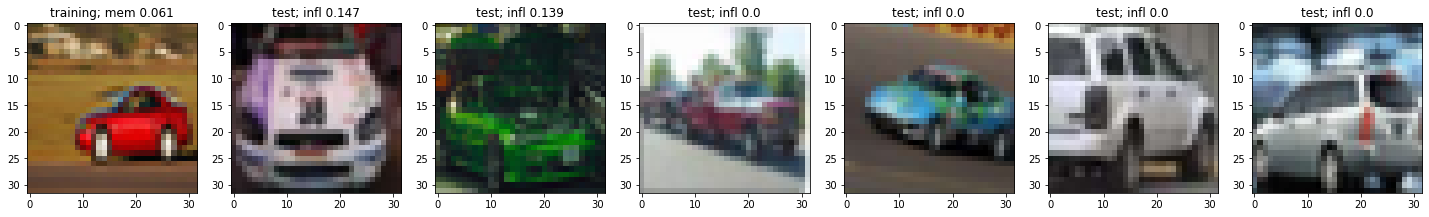

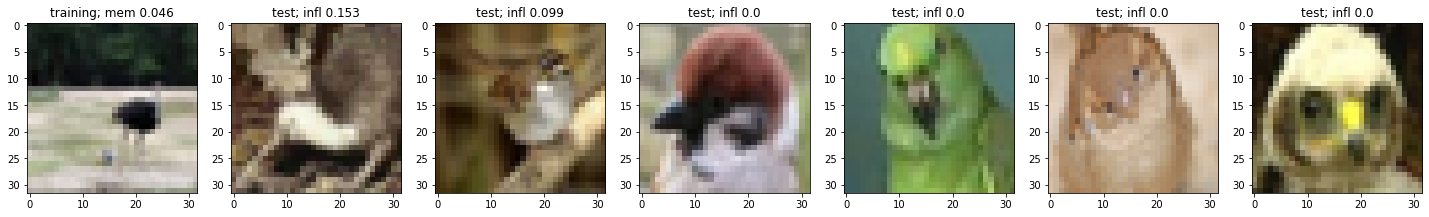

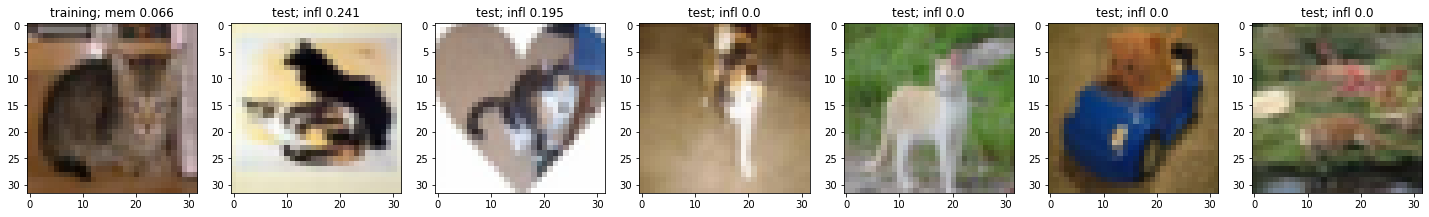

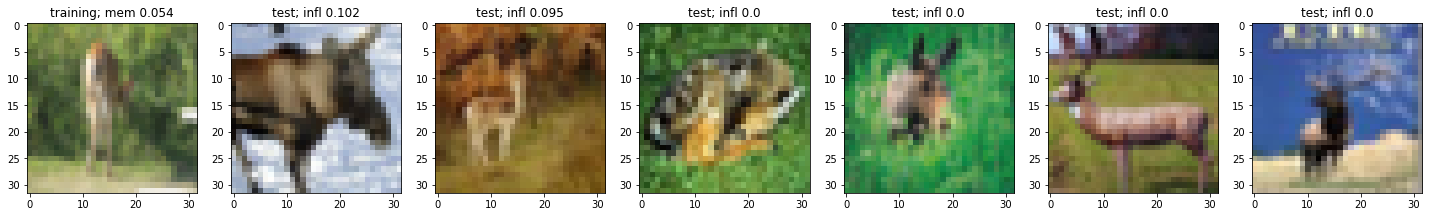

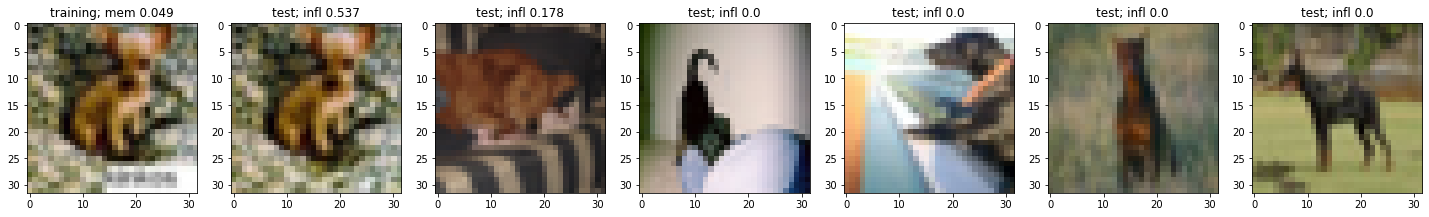

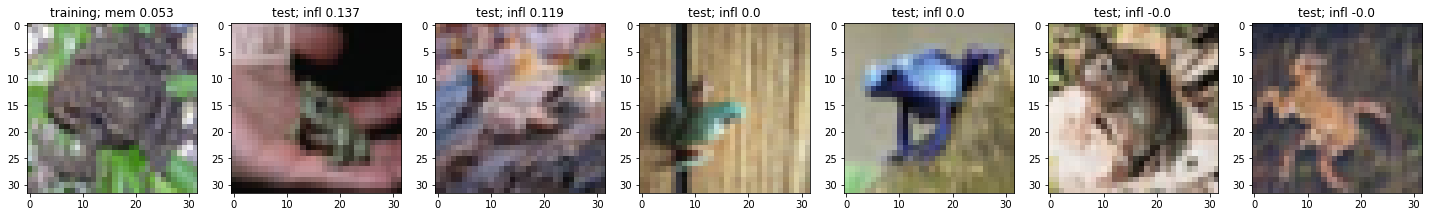

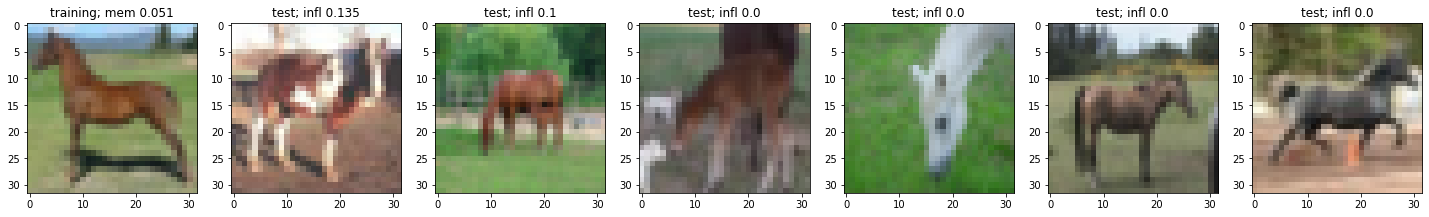

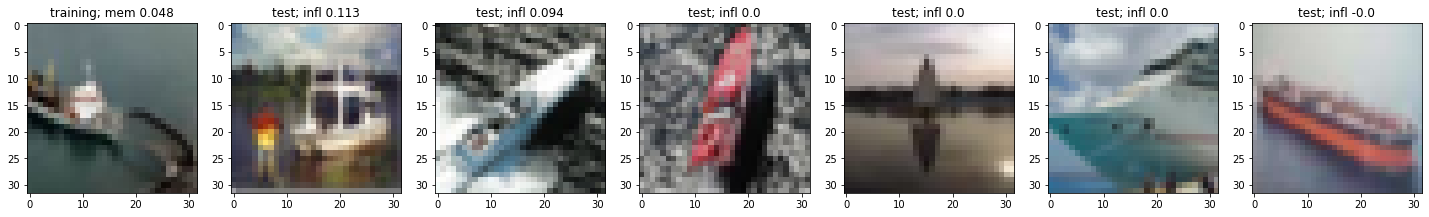

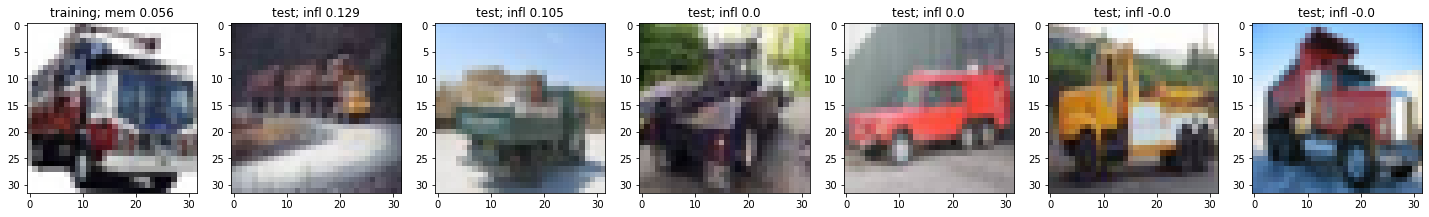

In [16]:
## TODO DO THEIR FIG 5
num_test = 6
num_pos = 2 ## high influence tests
num_low = num_test - num_pos ## low influence tests
num_train = len(classes)
rows = num_train
columns = num_test + 1
width = 25
height = width * (num_train / num_test)

test_ = testset
train_ = all_trainset
mem_ = out["mem_score"]
infl_ = out["infl_score_test"]
infl_idx = out["idx"]

for label in range(len(classes)):
    mask = (np.array(all_trainset.targets)[infl_idx]!=label) ## exclude other labels
    val_ = infl_.copy()
    val_[mask,:] = np.nan 
    k = np.argsort(- val_.max(axis = 1))[0] ## training sample with highest influence
    k_ = infl_idx[k]
    
    plt.figure(figsize=(width, height))
    r_ix = label
    plt.subplot(rows, columns, r_ix * columns + 1)
    plt.imshow(train_[k_][0])
    plt.title(f"training; mem {mem_[k_].round(3)}")
    
    mask = (np.array(test_.targets) != label)
    val_ = infl_[k, :].copy()
    val_[mask] = np.nan
    js = np.append(np.argsort(- val_)[:num_pos],
                  np.argsort(np.abs(val_))[:num_low])

    for c_ix, j in enumerate(js):
        plt.subplot(rows, columns, r_ix * columns + c_ix + 2)
        plt.imshow(test_[j][0])
        plt.title(f"test; infl {infl_[k, j].round(3)}")

### Training examples with largest memories

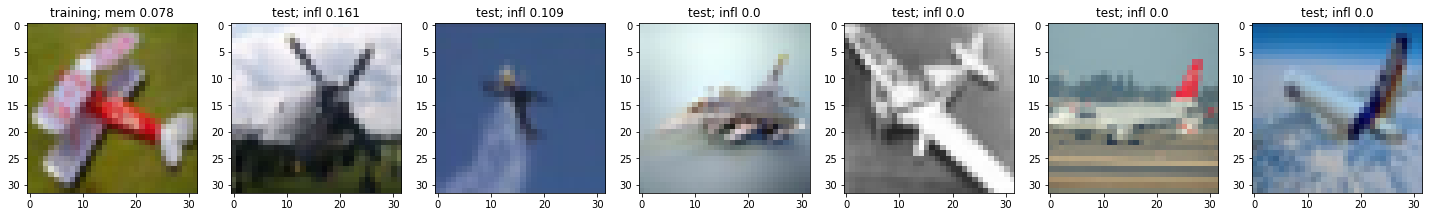

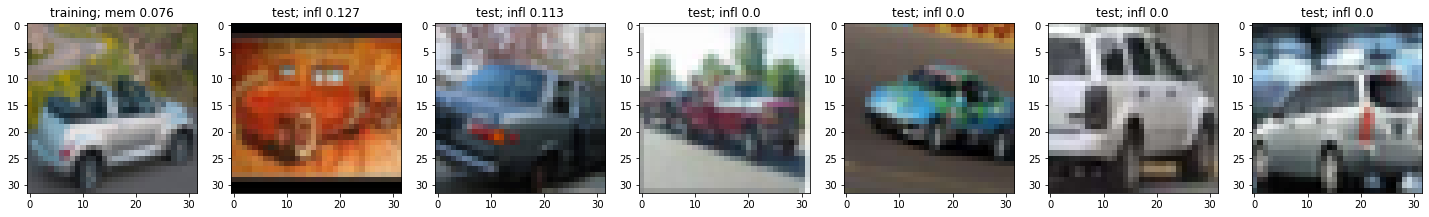

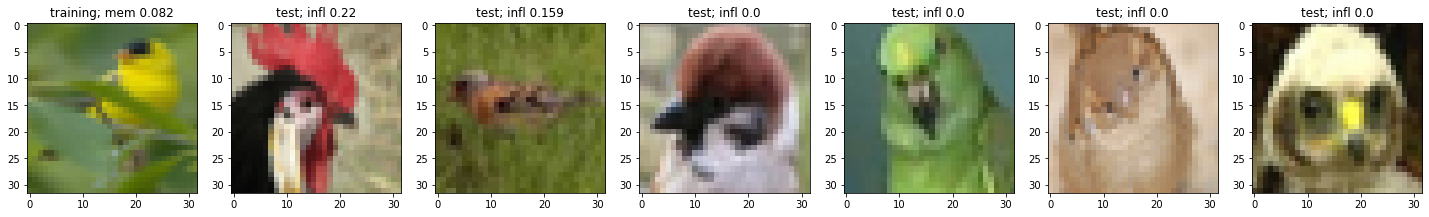

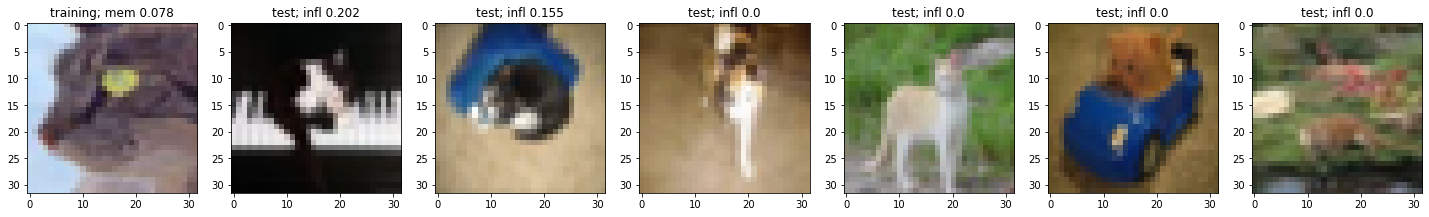

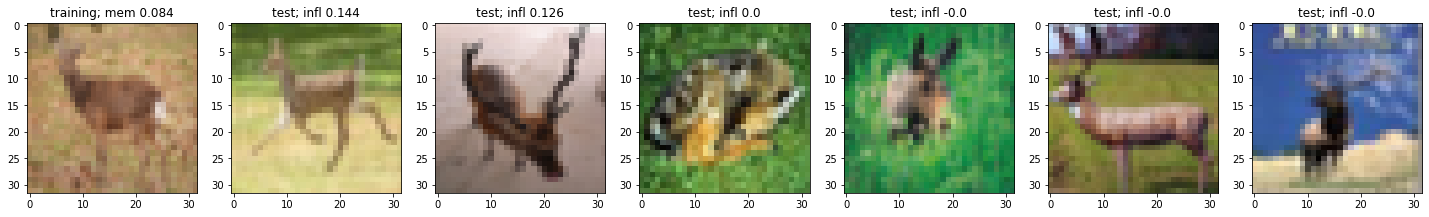

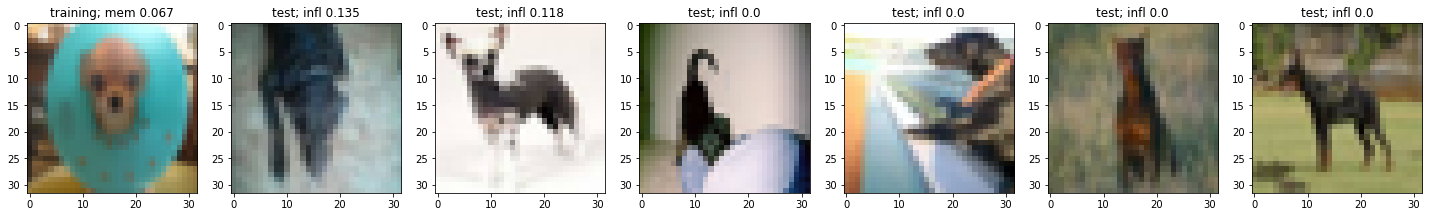

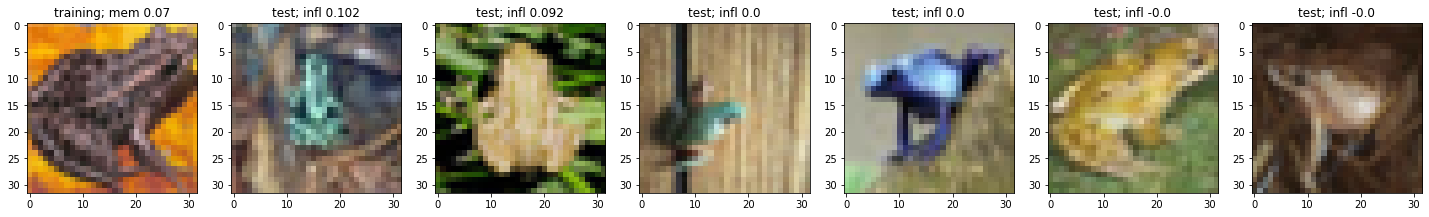

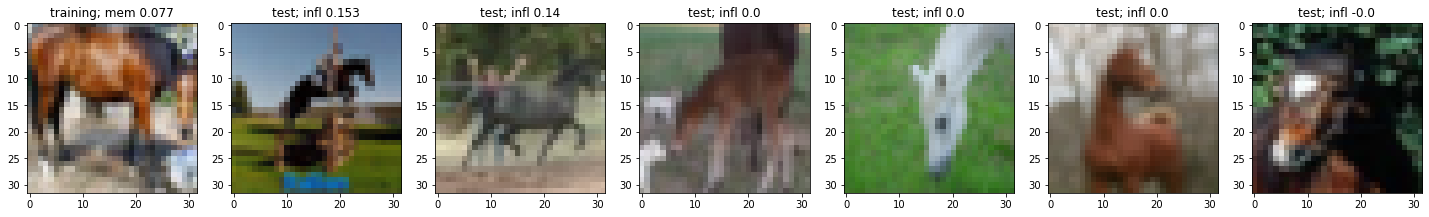

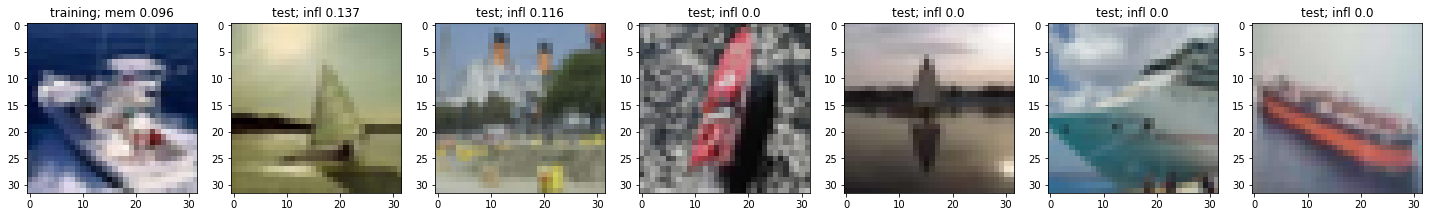

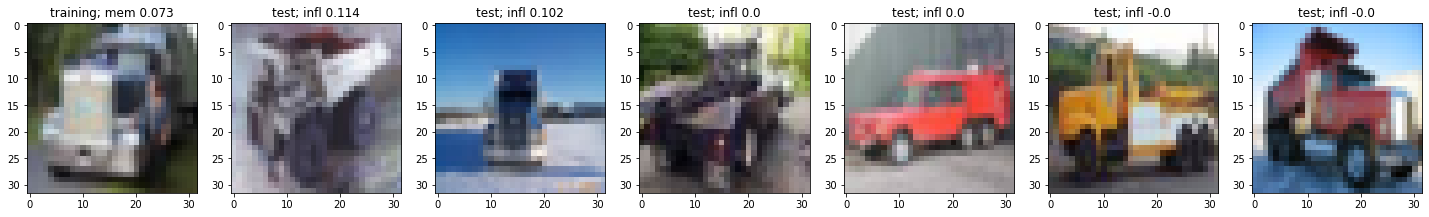

In [17]:
## TODO DO THEIR FIG 5
num_test = 6
num_pos = 2 ## high influence tests
num_low = num_test - num_pos ## low influence tests
num_train = len(classes)
rows = num_train
columns = num_test + 1
width = 25
height = width * (num_train / num_test)

test_ = testset
train_ = all_trainset
mem_ = out["mem_score"]
infl_ = out["infl_score_test"]
infl_idx = out["idx"]

for label in range(len(classes)):
    mask = (np.array(all_trainset.targets)!=label) ## exclude other labels
    val_ = mem_.copy()
    val_[mask] = np.nan 
    k_ = np.argsort(- val_)[0] ## training sample with highest mem
    k = np.where(infl_idx == k_)[0][0]
    
    plt.figure(figsize=(width, height))
    r_ix = label
    plt.subplot(rows, columns, r_ix * columns + 1)
    plt.imshow(train_[k_][0])
    plt.title(f"training; mem {mem_[k_].round(3)}")
    
    mask = (np.array(test_.targets) != label)
    val_ = infl_[k, :].copy()
    val_[mask] = np.nan
    js = np.append(np.argsort(- val_)[:num_pos],
                  np.argsort(np.abs(val_))[:num_low])

    for c_ix, j in enumerate(js):
        plt.subplot(rows, columns, r_ix * columns + c_ix + 2)
        plt.imshow(test_[j][0])
        plt.title(f"test; infl {infl_[k, j].round(3)}")

### Test examples with the highest influences

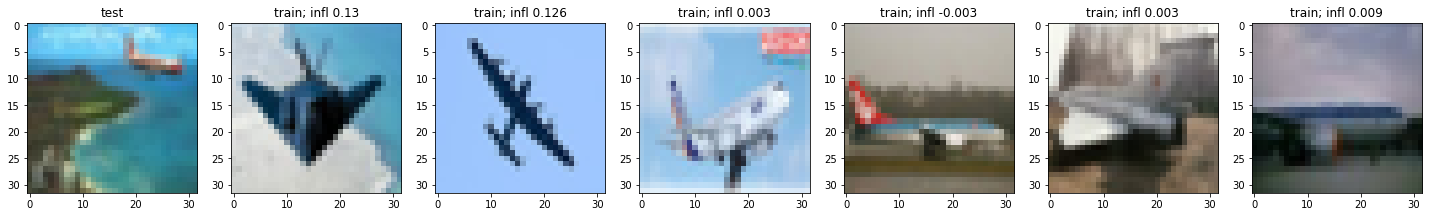

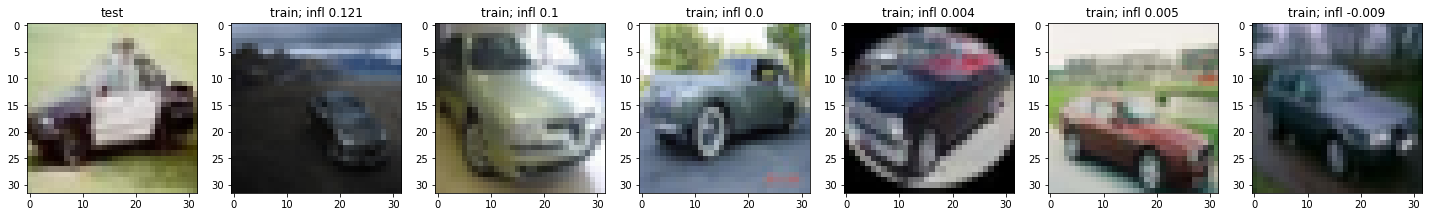

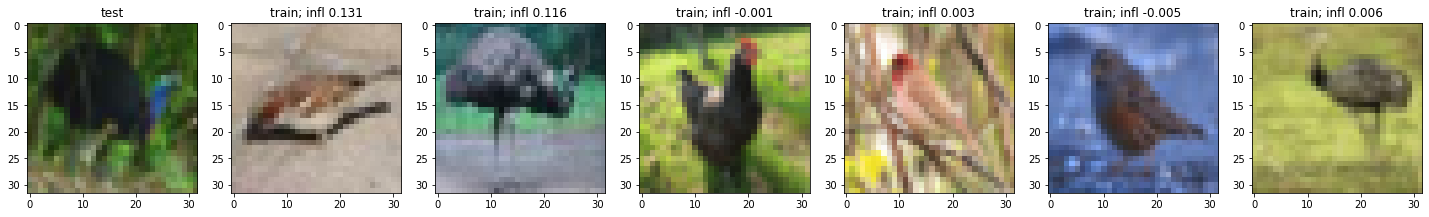

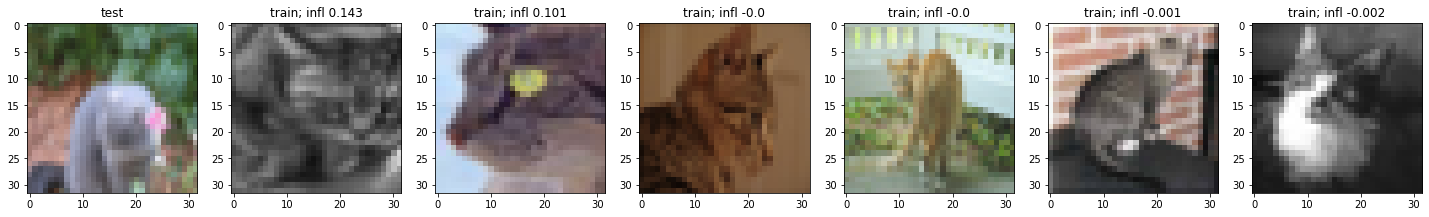

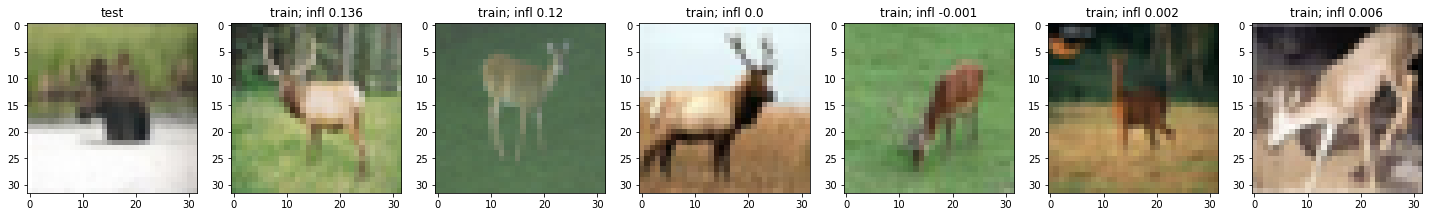

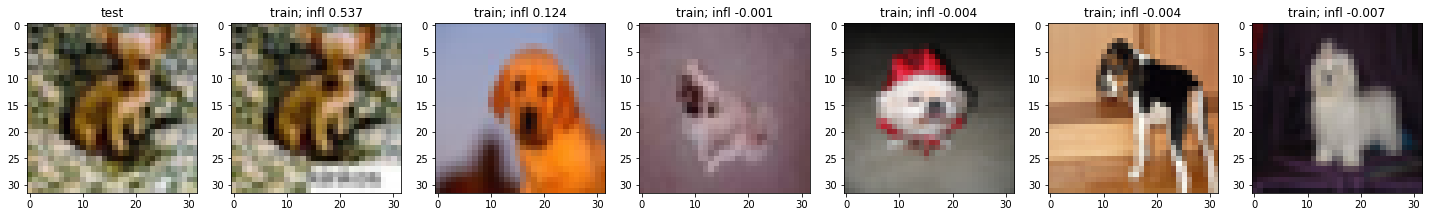

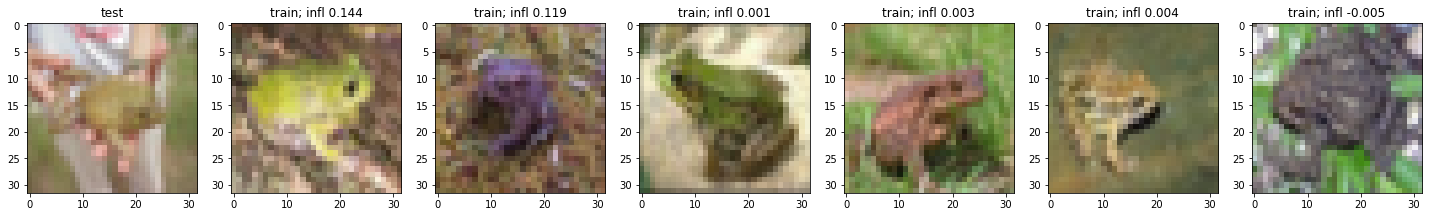

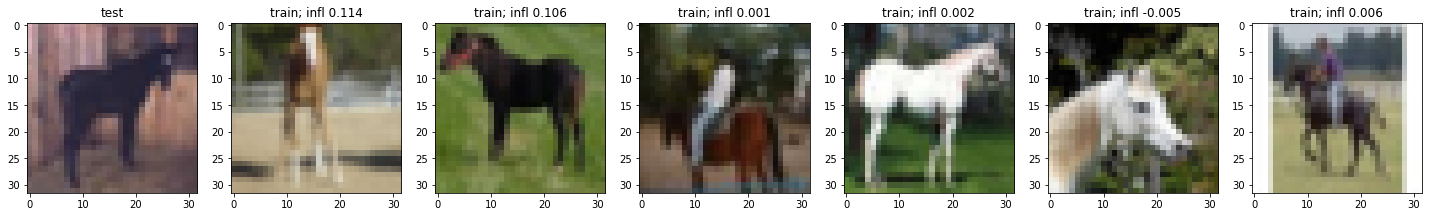

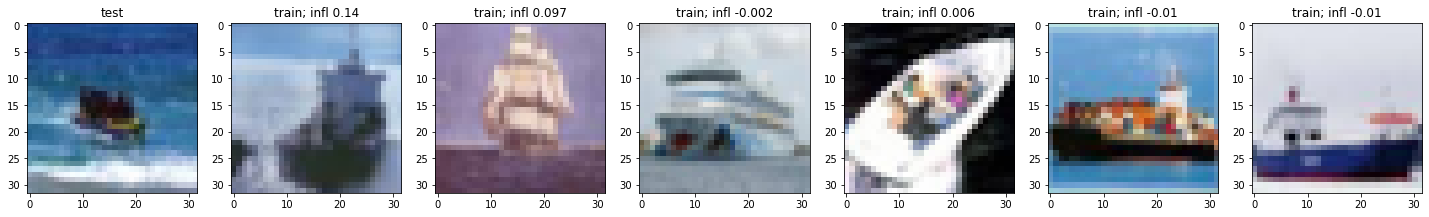

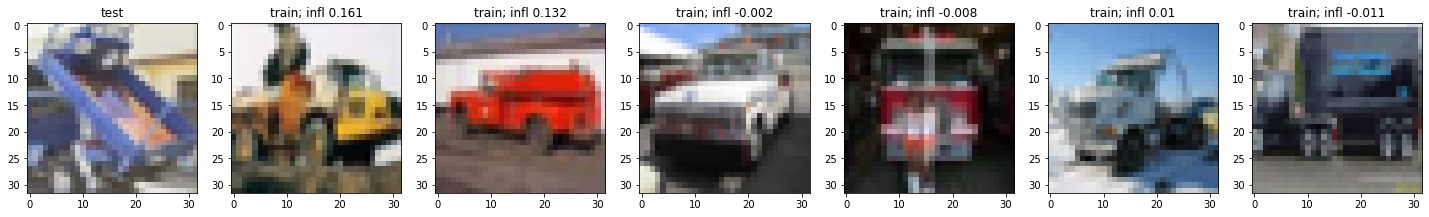

In [18]:
## TODO DO THEIR FIG 5
num_test = len(classes)
num_train = 6
num_pos = 2 ## high influence training
num_low = num_train - num_pos ## low influence training

rows = num_test
columns = num_train + 1
width = 25
height = width * (num_test / num_train)

test_ = testset
train_ = all_trainset
mem_ = out["mem_score"]
infl_ = out["infl_score_test"]
infl_idx = out["idx"]

for label in range(len(classes)):
    mask = (np.array(test_.targets)!=label) ## exclude other labels
    val_ = infl_.copy()
    val_[:, mask] = np.nan 
    j = np.argsort(- val_.max(axis = 0))[0] ## training sample with highest influence
    
    plt.figure(figsize=(width, height))
    r_ix = label
    plt.subplot(rows, columns, r_ix * columns + 1)
    plt.imshow(test_[j][0])
    plt.title("test")
    
    mask = (np.array(train_.targets)[infl_idx] != label)
    val_ = infl_[:, j].copy()
    val_[mask] = np.nan
    ks = np.append(np.argsort(- val_)[:num_pos],
                  np.argsort(np.abs(val_))[:num_low])

    for c_ix, k in enumerate(ks):
        k_ = infl_idx[k]
        plt.subplot(rows, columns, r_ix * columns + c_ix + 2)
        plt.imshow(train_[k_][0])
        plt.title(f"train; infl {infl_[k, j].round(3)}")

## New test data

### High influence pairs

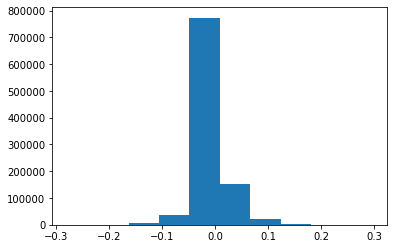

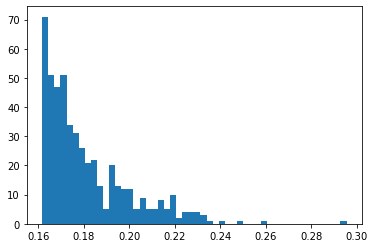

In [19]:
plt.hist(out['infl_score_testnew'].flatten())
plt.show()

cut = np.quantile(out['infl_score_testnew'].flatten(), 0.9995) ## should be more careful, but...
hinf_pairs2 = np.where(out['infl_score_testnew'] > cut)
hinf2 = out['infl_score_testnew'][out['infl_score_testnew'] > cut]
plt.hist(hinf2, bins = 50)
plt.show()

### training examples with the largest influences

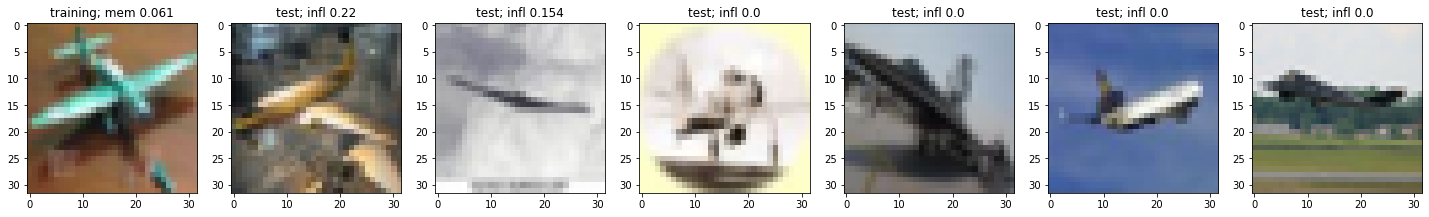

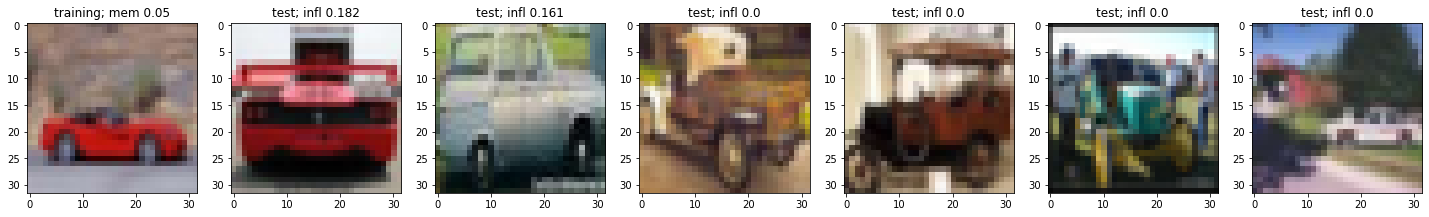

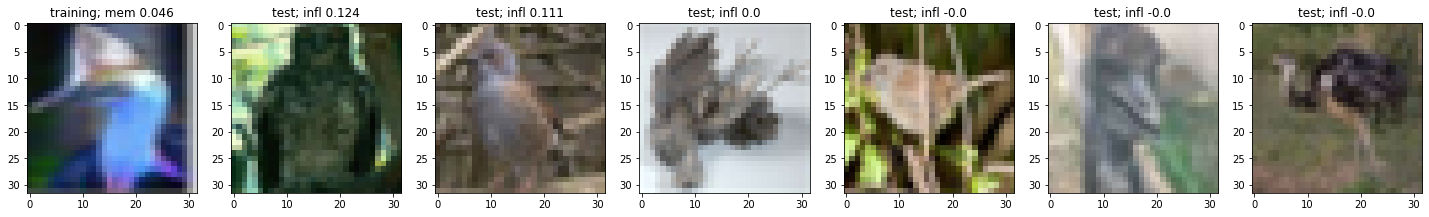

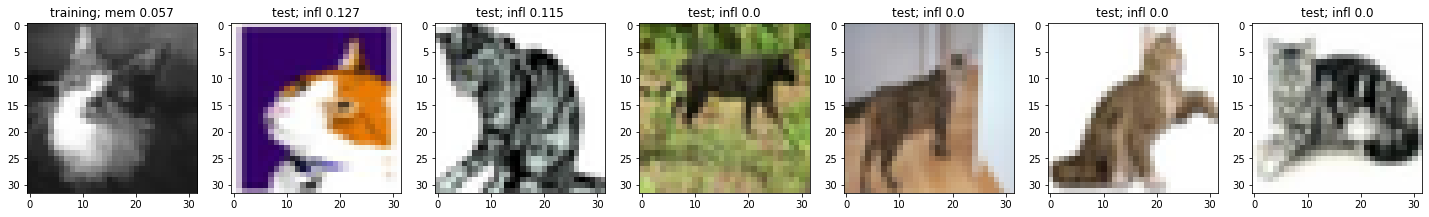

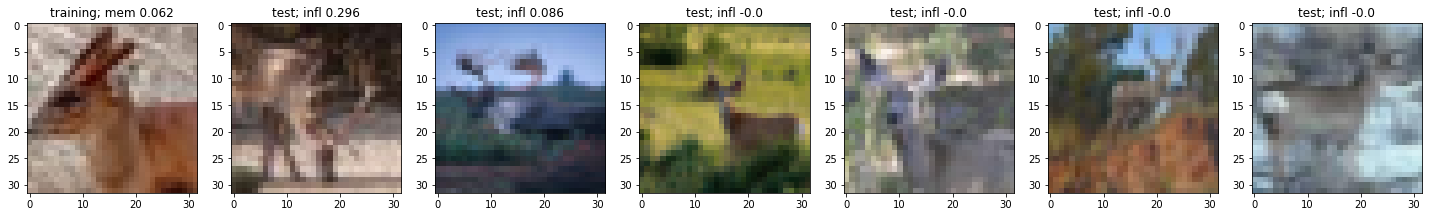

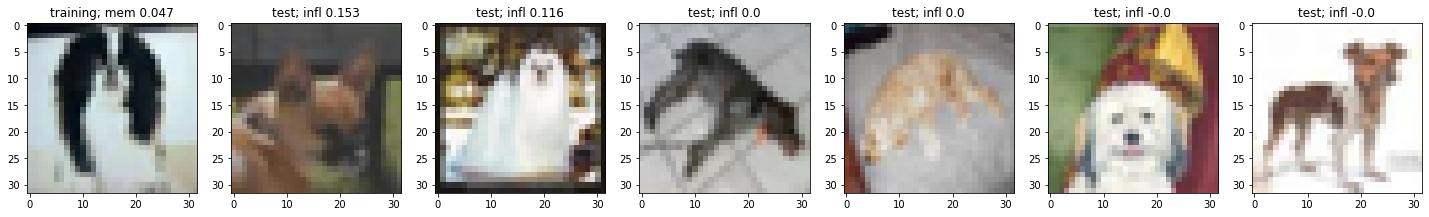

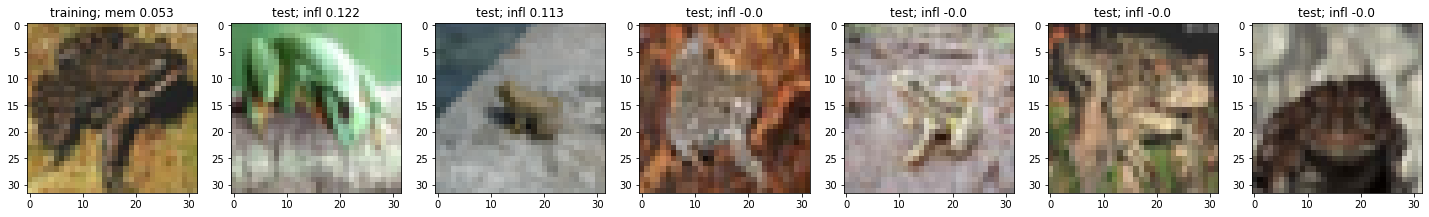

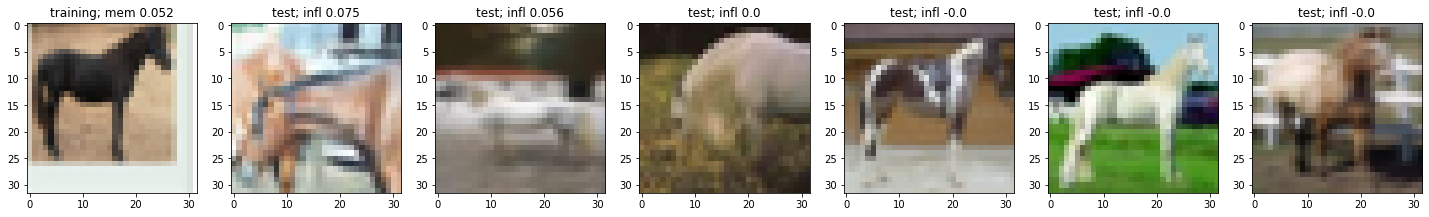

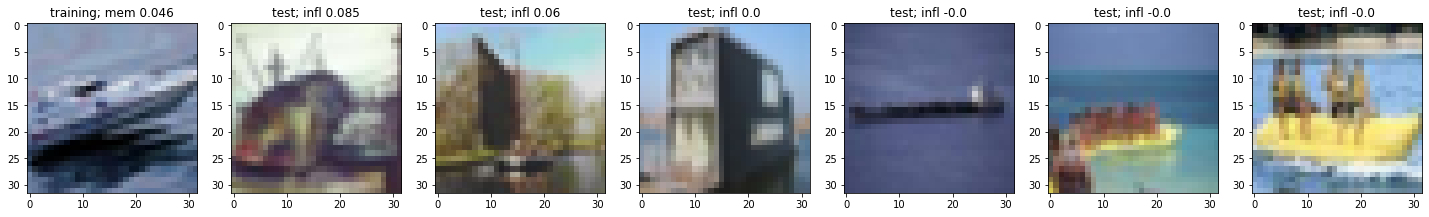

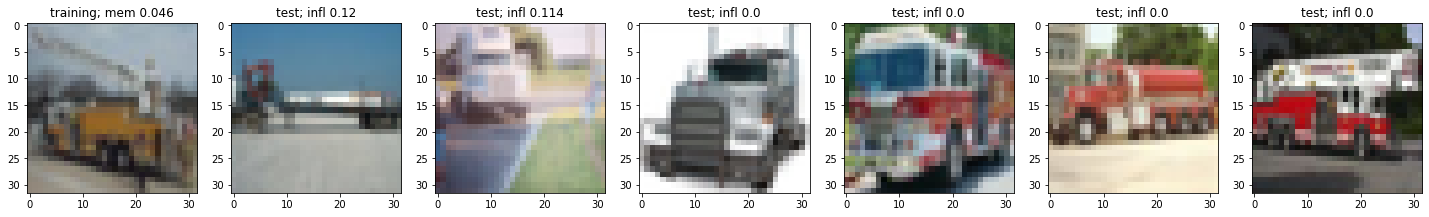

In [20]:
## TODO DO THEIR FIG 5
num_test = 6
num_pos = 2 ## high influence tests
num_low = num_test - num_pos ## low influence tests
num_train = len(classes)
rows = num_train
columns = num_test + 1
width = 25
height = width * (num_train / num_test)

test_ = testset_new
train_ = all_trainset
mem_ = out["mem_score"]
infl_ = out["infl_score_testnew"]
infl_idx = out["idx"]

for label in range(len(classes)):
    mask = (np.array(all_trainset.targets)[infl_idx]!=label) ## exclude other labels
    val_ = infl_.copy()
    val_[mask,:] = np.nan 
    k = np.argsort(- val_.max(axis = 1))[0] ## training sample with highest influence
    k_ = infl_idx[k]
    
    plt.figure(figsize=(width, height))
    r_ix = label
    plt.subplot(rows, columns, r_ix * columns + 1)
    plt.imshow(train_[k_][0])
    plt.title(f"training; mem {mem_[k_].round(3)}")
    
    mask = (np.array(test_.targets) != label)
    val_ = infl_[k, :].copy()
    val_[mask] = np.nan
    js = np.append(np.argsort(- val_)[:num_pos],
                  np.argsort(np.abs(val_))[:num_low])

    for c_ix, j in enumerate(js):
        plt.subplot(rows, columns, r_ix * columns + c_ix + 2)
        plt.imshow(test_[j][0])
        plt.title(f"test; infl {infl_[k, j].round(3)}")

### Training samples with the highest memories

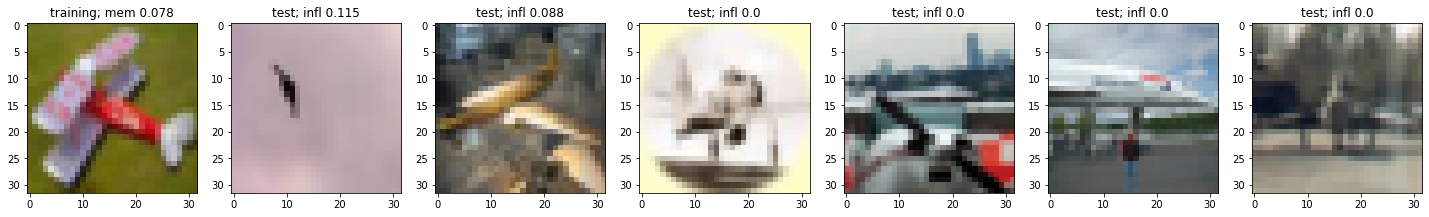

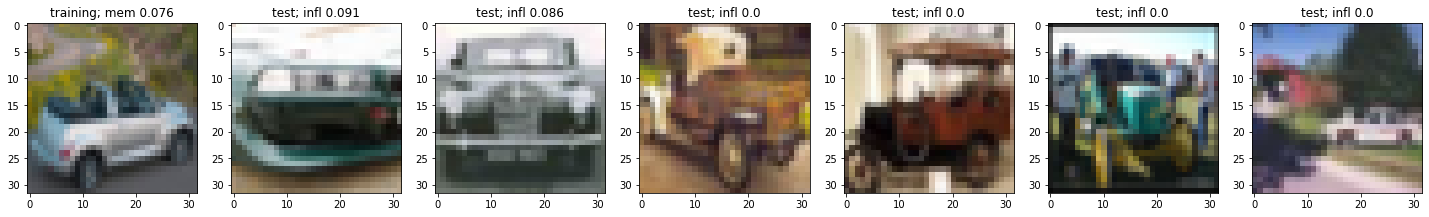

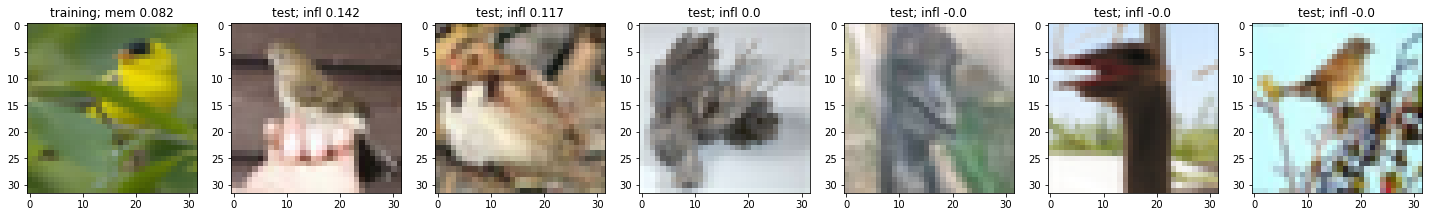

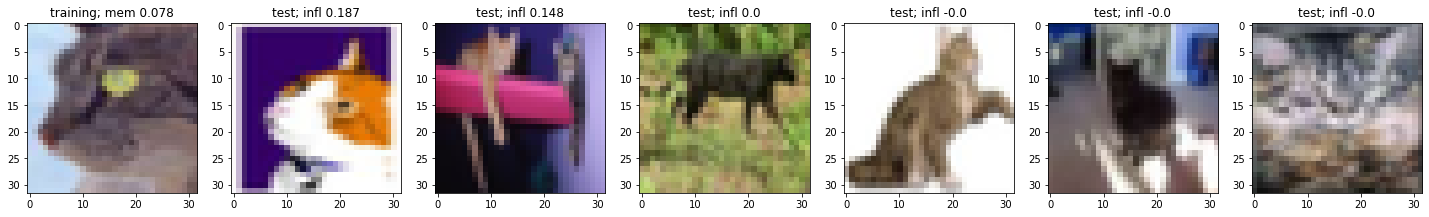

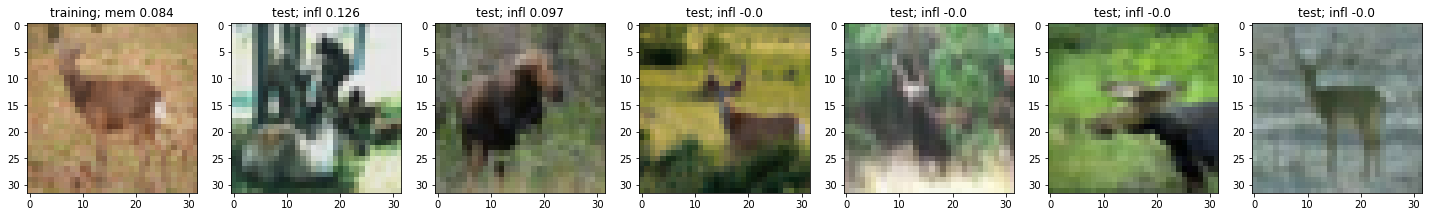

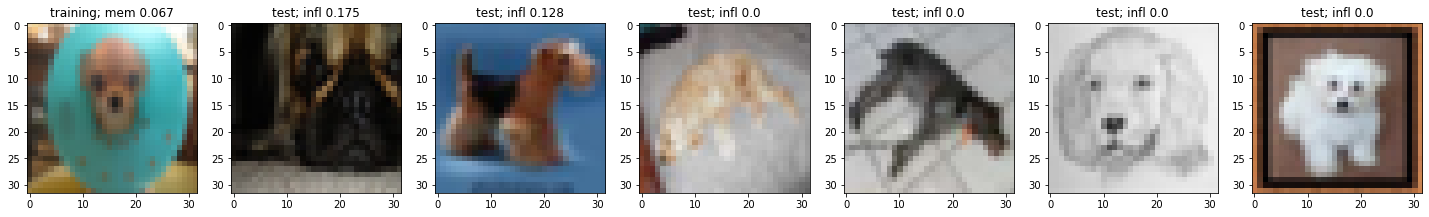

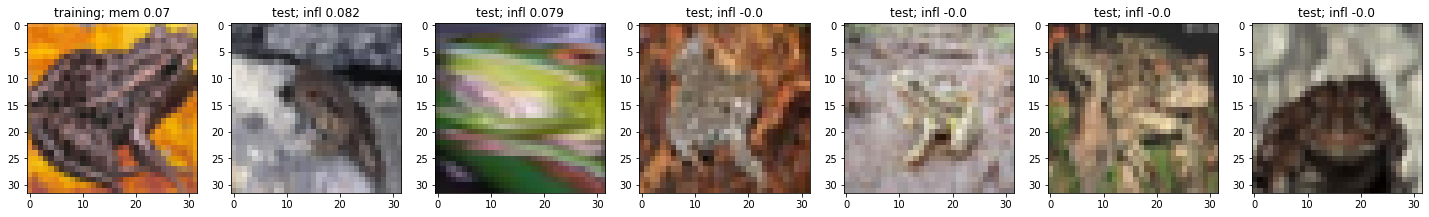

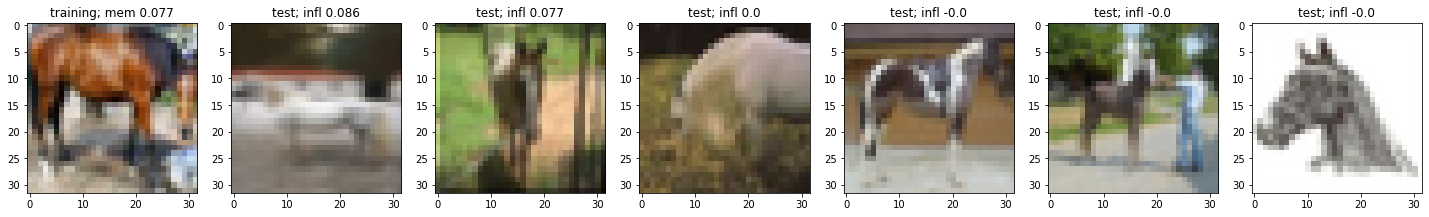

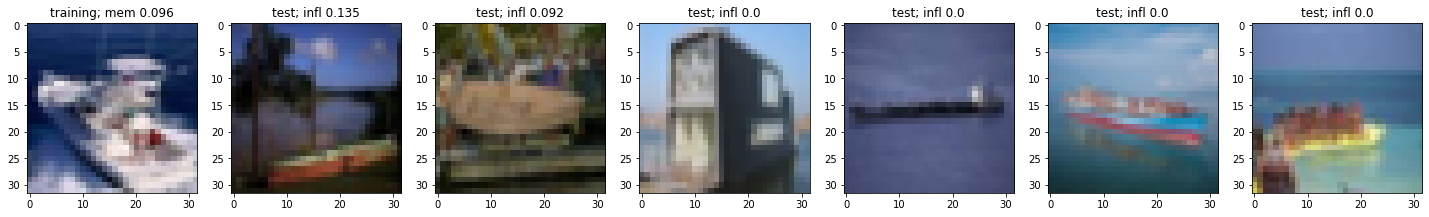

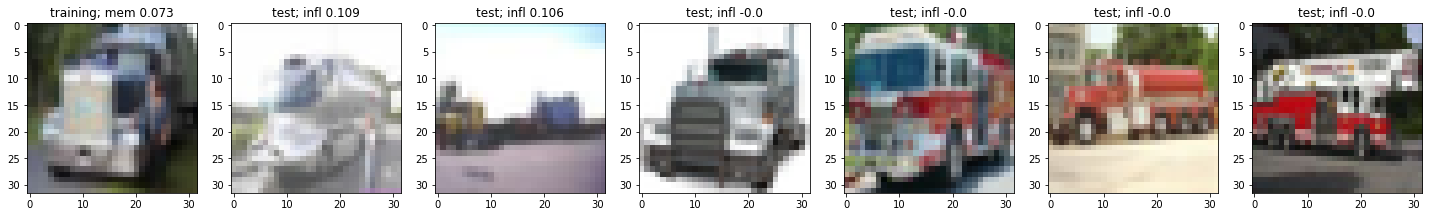

In [21]:
## TODO DO THEIR FIG 5
num_test = 6
num_pos = 2 ## high influence tests
num_low = num_test - num_pos ## low influence tests
num_train = len(classes)
rows = num_train
columns = num_test + 1
width = 25
height = width * (num_train / num_test)

test_ = testset_new
train_ = all_trainset
mem_ = out["mem_score"]
infl_ = out["infl_score_testnew"]
infl_idx = out["idx"]

for label in range(len(classes)):
    mask = (np.array(all_trainset.targets)!=label) ## exclude other labels
    val_ = mem_.copy()
    val_[mask] = np.nan 
    k_ = np.argsort(- val_)[0] ## training sample with highest mem
    k = np.where(infl_idx == k_)[0][0]
    
    plt.figure(figsize=(width, height))
    r_ix = label
    plt.subplot(rows, columns, r_ix * columns + 1)
    plt.imshow(train_[k_][0])
    plt.title(f"training; mem {mem_[k_].round(3)}")
    
    mask = (np.array(test_.targets) != label)
    val_ = infl_[k, :].copy()
    val_[mask] = np.nan
    js = np.append(np.argsort(- val_)[:num_pos],
                  np.argsort(np.abs(val_))[:num_low])

    for c_ix, j in enumerate(js):
        plt.subplot(rows, columns, r_ix * columns + c_ix + 2)
        plt.imshow(test_[j][0])
        plt.title(f"test; infl {infl_[k, j].round(3)}")

## Test samples with the highest influences

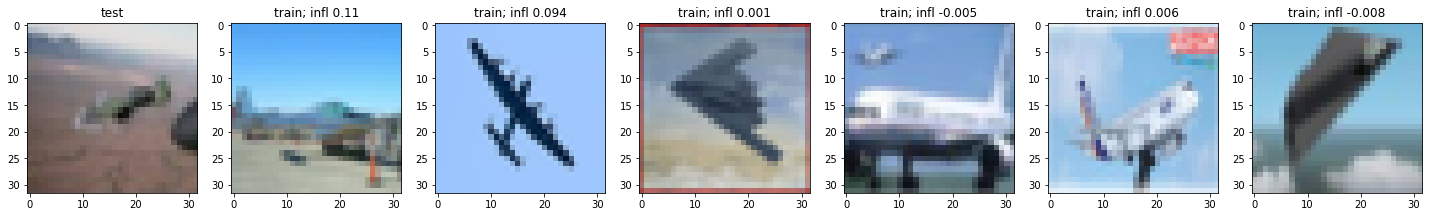

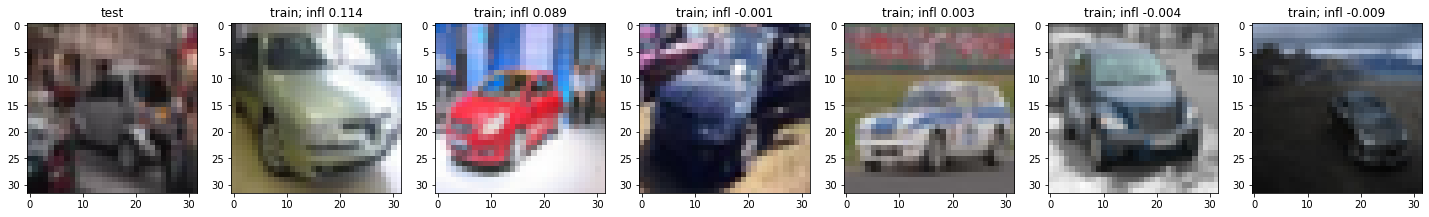

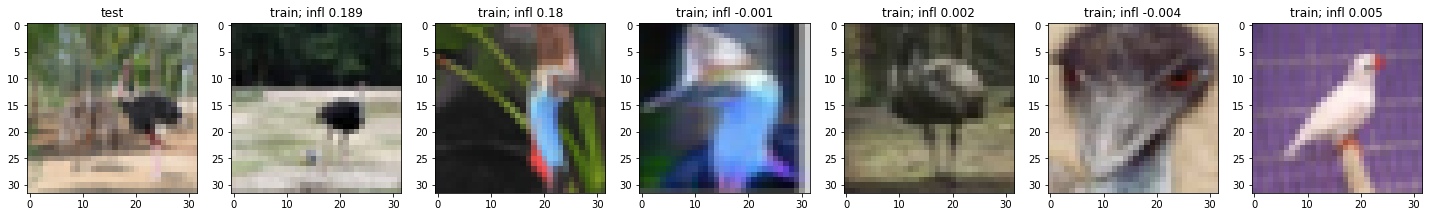

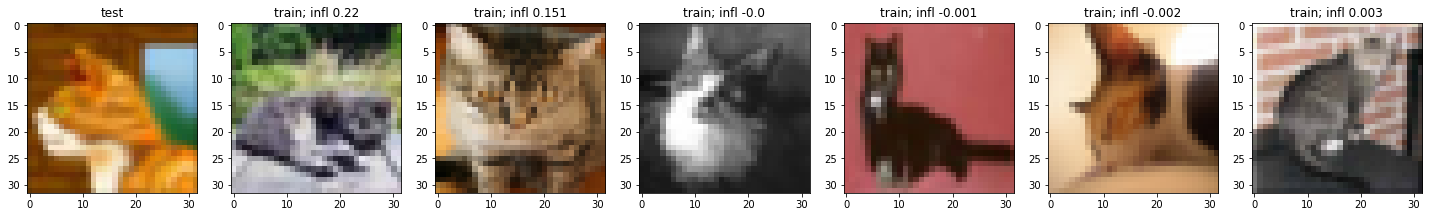

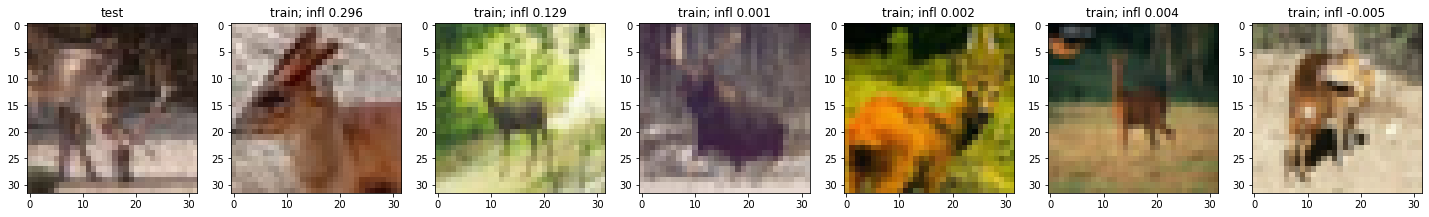

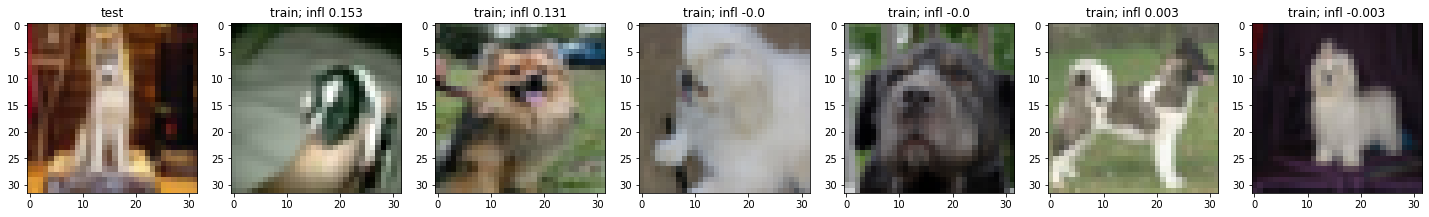

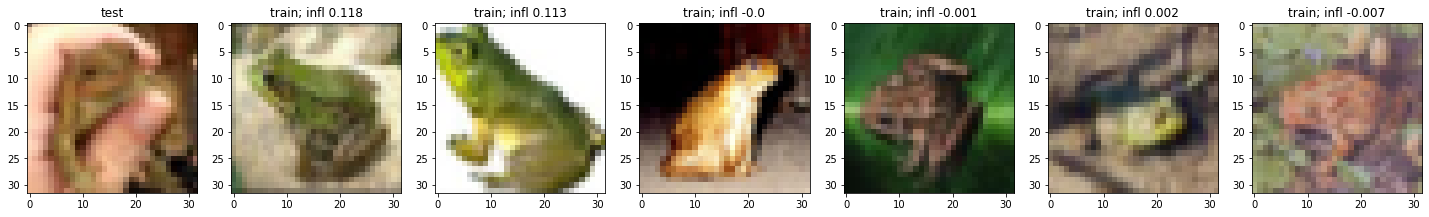

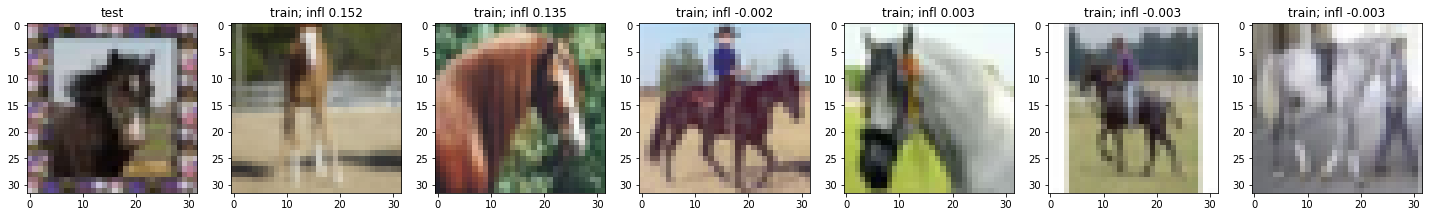

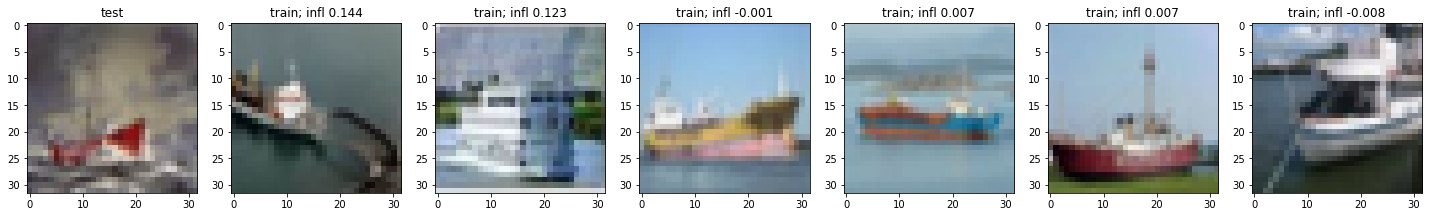

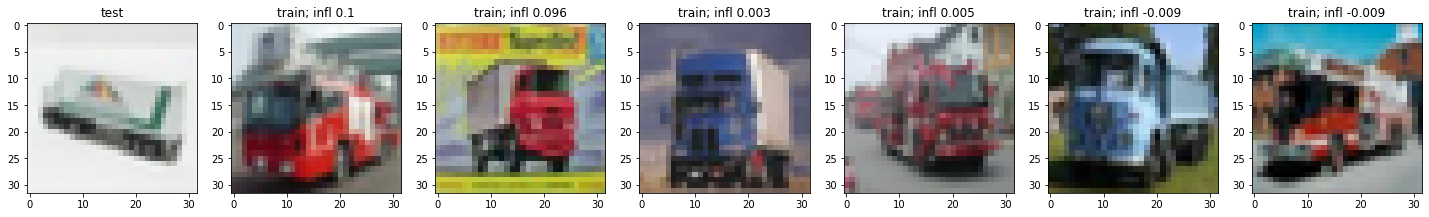

In [22]:
## TODO DO THEIR FIG 5
num_test = len(classes)
num_train = 6
num_pos = 2 ## high influence training
num_low = num_train - num_pos ## low influence training

rows = num_test
columns = num_train + 1
width = 25
height = width * (num_test / num_train)

test_ = testset_new
train_ = all_trainset
mem_ = out["mem_score"]
infl_ = out["infl_score_testnew"]
infl_idx = out["idx"]

for label in range(len(classes)):
    mask = (np.array(test_.targets)!=label) ## exclude other labels
    val_ = infl_.copy()
    val_[:, mask] = np.nan 
    j = np.argsort(- val_.max(axis = 0))[0] ## training sample with highest influence
    
    plt.figure(figsize=(width, height))
    r_ix = label
    plt.subplot(rows, columns, r_ix * columns + 1)
    plt.imshow(test_[j][0])
    plt.title("test")
    
    mask = (np.array(train_.targets)[infl_idx] != label)
    val_ = infl_[:, j].copy()
    val_[mask] = np.nan
    ks = np.append(np.argsort(- val_)[:num_pos],
                  np.argsort(np.abs(val_))[:num_low])

    for c_ix, k in enumerate(ks):
        k_ = infl_idx[k]
        plt.subplot(rows, columns, r_ix * columns + c_ix + 2)
        plt.imshow(train_[k_][0])
        plt.title(f"train; infl {infl_[k, j].round(3)}")

### Comment:

* Some influence pairs indeed look more similar than low-influence pairs. 

* Compare the high-mem samples' influences on test and new-test data. The influences are larger in test data. 

## Accuracy vs influence

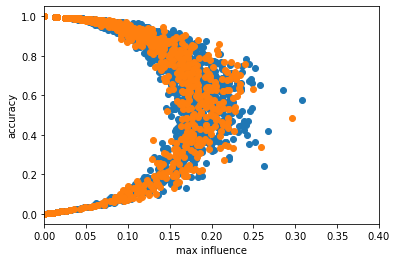

In [42]:
infl1 = out["infl_score_test"].max(axis = 0)
infl2 = out["infl_score_testnew"].max(axis = 0)
acc1 = out["acc_test"].mean(axis = 0)
acc2= out["acc_test_new"].mean(axis = 0)

plt.scatter(infl1, acc1)
plt.scatter(infl2, acc2)
plt.xlim([0, 0.4])
plt.xlabel("max influence")
plt.ylabel("accuracy")
plt.show()

## Influence to predict accuracy? 

/scratch/local/jobs/4037377/ipykernel_1200969/1540139281.py:3: RuntimeWarning: Mean of empty slice.
  acc2s = [acc2[infl2 > t].mean() for t in thresholds]


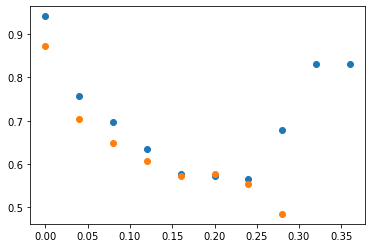

In [57]:
thresholds = [0.04 * i for i in range(10)]
acc1s = [acc1[infl1 > t].mean() for t in thresholds]
acc2s = [acc2[infl2 > t].mean() for t in thresholds]

plt.scatter(thresholds, acc1s)
plt.scatter(thresholds, acc2s)
plt.show()

/scratch/local/jobs/4037377/ipykernel_1200969/2228270890.py:8: RuntimeWarning: Mean of empty slice.
  acc2s = [acc2[np.logical_and((infl2 > l), (infl2 < u))].mean() for (l, u) in zip(thres_l, thres_u)]


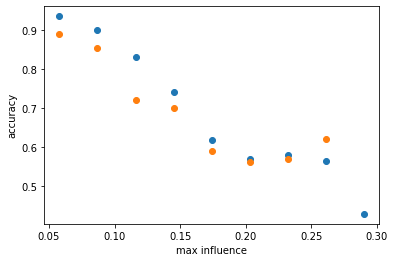

In [84]:
thres_l = [0.029 * i for i in range(1, 11)]
thres_u = thres_l[1:].copy()
thres_l = thres_l[:-1].copy()

import itertools 

acc1s = [acc1[np.logical_and((infl1 > l), (infl1 < u))].mean() for (l, u) in zip(thres_l, thres_u)]
acc2s = [acc2[np.logical_and((infl2 > l), (infl2 < u))].mean() for (l, u) in zip(thres_l, thres_u)]
    
plt.scatter(thres_u, acc1s)
plt.scatter(thres_u, acc2s)
plt.xlabel("max influence")
plt.ylabel("accuracy")
plt.show()